In [83]:
#loading required libraries

## Data manipulation
import pandas as pd
import numpy as np

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display all columns
pd.set_option('display.max_columns', None)

# Checking for stationarity for the time series data
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

# ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#impulse response
#from statsmodels.tsa.impulse_response import ImpulseResponseResults

# Random Forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Evaluation metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

# Research Question:

- What is the relationship between exchange rate and trade balances?

# Business Understanding

Exchange rate is the price of one country‟s currency in relation to another country‟s, which is a key variable for robust economic management in every nation. Imports are an important indicator of an economy's health. A high level of imports indicates robust domestic demand and a growing economy. When net exports exceed imports the nation has a trade surplus. If exports are growing but imports sharply decline, it means that the rest of the world is in better shape than the domestic economy and vice versa. A rising level of imports and a growing trade deficit, when imports exceed exports can have a negative effect on the level of domestic currency against foreign currency. 

In general a weaker domestic currency, stimulates exports and makes imports more expensive. A strong domestic currency hampers exports and makes imports cheaper. A rising level of imports and a growing trade deficit can have a negative effect on a country's exchange rate.

Link: https://www.investopedia.com/articles/investing/100813/interesting-facts-about-imports-and-exports.asp

# Data Understanding

## Exchange Rate Data

In [84]:
#loading the exchange Rate data
exchange_data = pd.read_csv("Monthly exchange rates.csv")

# first 5 rows
exchange_data


,Year,Month,fx rate
0,2023,12,154.09
1,2023,11,152.03
2,2023,10,149.40
3,2023,9,146.77
4,2023,8,143.93
...,...,...,...
307,1998,5,62.60
308,1998,4,59.61
309,1998,3,60.13
310,1998,2,60.52


In [85]:
# Descriptive Statistics
exchange_data.describe()

,Year,Month,fx rate
count,312.000000,312.000000,312.000000
mean,2010.500000,6.500000,87.984872
std,7.512048,3.457598,18.174099
min,1998.000000,1.000000,59.340000
25%,2004.000000,3.750000,76.007500
50%,2010.500000,6.500000,81.315000
75%,2017.000000,9.250000,101.492500
max,2023.000000,12.000000,154.090000


**Insight Drawn:**
- The data is from 1998 to 2023
- The highest exchange rate is 154.09 with the lowest being 59.34
- Since the mean is > than the median(50%), suggest that the exchange rate is skewed to the right, suggesting presence of outliers

In [86]:
# Info on the dataset
exchange_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     312 non-null    int64  
 1   Month    312 non-null    int64  
 2   fx rate  312 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 7.4 KB


**Insight Drawn:**
- No missing values in the dataset

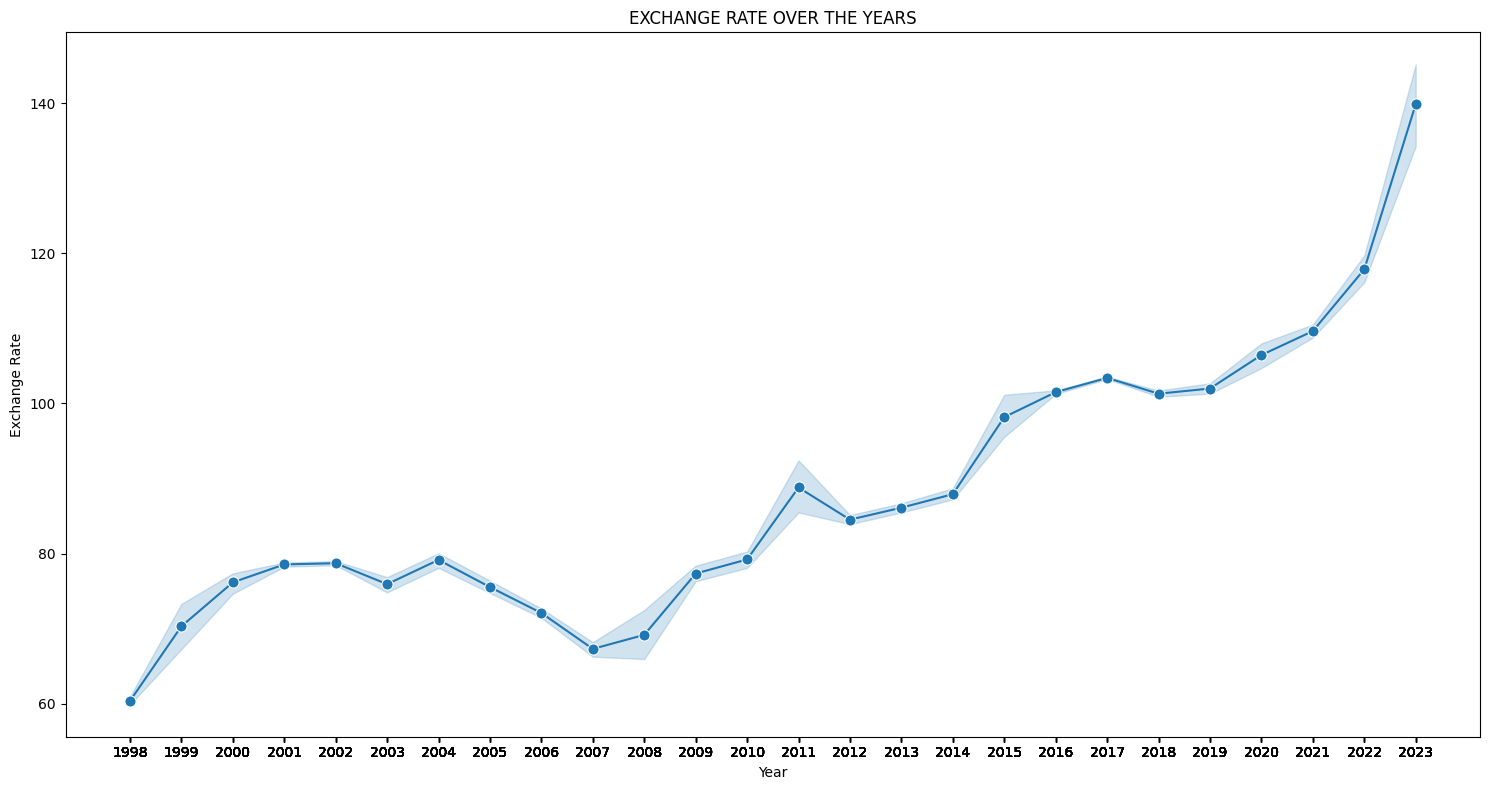

In [87]:
# Attempting to use seaborn

# Defining the figure size
plt.figure(figsize=(15,8))
sns.lineplot(data=exchange_data,x='Year', y='fx rate', marker='o', markersize=8)

# Adjust the plot appearance
plt.title('EXCHANGE RATE OVER THE YEARS')
plt.xlabel('Year')
plt.ylabel('Exchange Rate')
plt.xticks(exchange_data['Year'])
plt.tight_layout()

# Show the plot
plt.show()



### Checking for stationarity

1. Writing down the hypothesis:

     - Null hypothesis: Non-stationary          vs           Alternative hypothesis: Stationary

2. Defining the level of significance: alpha = 0.05

3. Stationarity test : ADF test



In [88]:
# Performing the adf test
result = adfuller(exchange_data['fx rate'],autolag='AIC')

# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis; the time series is stationary.")
else:
    print("Fail to reject the null hypothesis; the time series is not stationary.")


ADF Statistic: -3.200432852094083
p-value: 0.0199596377074848
Critical Values: {'1%': -3.45176116018037, '5%': -2.870970093607691, '10%': -2.571794416006072}
Reject the null hypothesis; the time series is stationary.


**Insights:**
- The exchange rate data is stationary.

## Imports Data

In [89]:
imports = pd.read_csv("Value of Direct Imports from Selected African and other Countries (Ksh. Million).csv")
imports.head()

,Year,Month,Uganda,Tanzania,Zambia,Egypt,S.Africa,Zimbabwe,Other,Total,Year.1,Month.1,UK,USA,Germany,Italy,UAE,S.Arabia,France,India,S.Africa.1,Japan,Others,Total.1
0,2023,June,3039,3915,599,4325,6748,791,2263,21680,2023,June,3588,12020,5178,1695,32248,7655,2330,21412,6748,8748,108546,210166
1,2023,December,2134,3470,340,4359,5125,450,3745,19622,2023,December,2435,8453,3382,1709,31030,5007,2500,19295,5125,8877,131851,219664
2,2023,January,2922,2386,181,3517,3267,93,9409,21776,2023,January,3658,5769,2995,1740,33077,4013,4376,24201,3267,6822,105295,195214
3,2023,February,3016,2692,232,3313,5790,208,2441,17691,2023,February,2509,5766,3695,963,35619,7170,1436,13993,5790,5670,93461,176071
4,2023,March,3191,2909,213,4741,7319,361,3682,22416,2023,March,2479,6916,2916,2678,13925,32265,2052,27320,7319,8033,111778,217680


In [90]:
# Obtaining the descriptive statistics
imports.describe()

,Year,Uganda,Tanzania,Zambia,Egypt,S.Africa,Zimbabwe,Other,Total,Year.1,UK,USA,Germany,Italy,UAE,S.Arabia,France,India,S.Africa.1,Japan,Others,Total.1
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.00000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000
mean,2010.500000,1237.269231,1205.089744,266.205128,1734.698718,3923.907051,113.038462,1660.99359,10141.099359,2010.500000,2869.221154,4453.756410,2432.134615,1276.647436,9827.891026,4789.634615,1501.480769,10570.323718,3924.919872,4760.326923,46043.076923,92363.887821
std,7.512048,1388.021147,1340.644796,279.890360,1433.590372,2061.586829,158.837897,1557.05041,6706.147355,7.512048,1410.426322,4848.652561,1413.342337,758.462502,9051.905166,4765.059614,762.213168,8685.280597,2063.000161,2876.261286,35289.433069,61788.988823
min,1998.000000,0.000000,17.000000,0.000000,5.000000,258.000000,0.000000,26.00000,1021.000000,1998.000000,1054.000000,306.000000,414.000000,168.000000,313.000000,88.000000,360.000000,109.000000,258.000000,544.000000,4698.000000,13453.000000
25%,2004.000000,54.000000,145.500000,56.500000,445.500000,2291.250000,16.750000,574.00000,3815.250000,2004.000000,2065.000000,1328.500000,1134.250000,642.250000,3521.750000,1387.500000,868.250000,1590.500000,2291.250000,1894.500000,11354.250000,29693.500000
50%,2010.500000,763.000000,874.500000,178.500000,1445.000000,3886.500000,52.000000,1263.50000,10184.000000,2010.500000,2644.000000,3757.000000,2310.000000,1256.500000,7388.500000,2826.500000,1475.000000,10125.500000,3886.500000,4546.000000,42804.000000,89584.500000
75%,2017.000000,2126.500000,1546.000000,372.000000,2862.250000,5357.500000,126.000000,2312.75000,14686.500000,2017.000000,3285.250000,5577.000000,3322.000000,1722.500000,12354.750000,6685.500000,1932.500000,17363.500000,5357.500000,7392.500000,72481.750000,139404.500000
max,2023.000000,7587.000000,6549.000000,1556.000000,5936.000000,11843.000000,950.000000,9409.00000,27075.000000,2023.000000,18516.000000,49517.000000,7830.000000,5986.000000,50048.000000,32265.000000,4833.000000,34138.000000,11843.000000,13797.000000,153420.000000,259111.000000


### Africa Imports

In [91]:
# Extracting Africa imports
africa_imports = imports[['Year','Month','Uganda','Tanzania','Zambia','Egypt','S.Africa','Zimbabwe','Other','Total']]
africa_imports

,Year,Month,Uganda,Tanzania,Zambia,Egypt,S.Africa,Zimbabwe,Other,Total
0,2023,June,3039,3915,599,4325,6748,791,2263,21680
1,2023,December,2134,3470,340,4359,5125,450,3745,19622
2,2023,January,2922,2386,181,3517,3267,93,9409,21776
3,2023,February,3016,2692,232,3313,5790,208,2441,17691
4,2023,March,3191,2909,213,4741,7319,361,3682,22416
...,...,...,...,...,...,...,...,...,...,...
307,1998,September,2,56,21,10,973,19,81,1162
308,1998,November,9,61,1,9,1118,25,188,1410
309,1998,December,2,105,0,51,998,36,310,1502
310,1998,January,2,39,13,16,1229,30,109,1438


In [92]:
africa_imports.describe()

,Year,Uganda,Tanzania,Zambia,Egypt,S.Africa,Zimbabwe,Other,Total
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.00000,312.000000
mean,2010.500000,1237.269231,1205.089744,266.205128,1734.698718,3923.907051,113.038462,1660.99359,10141.099359
std,7.512048,1388.021147,1340.644796,279.890360,1433.590372,2061.586829,158.837897,1557.05041,6706.147355
min,1998.000000,0.000000,17.000000,0.000000,5.000000,258.000000,0.000000,26.00000,1021.000000
25%,2004.000000,54.000000,145.500000,56.500000,445.500000,2291.250000,16.750000,574.00000,3815.250000
50%,2010.500000,763.000000,874.500000,178.500000,1445.000000,3886.500000,52.000000,1263.50000,10184.000000
75%,2017.000000,2126.500000,1546.000000,372.000000,2862.250000,5357.500000,126.000000,2312.75000,14686.500000
max,2023.000000,7587.000000,6549.000000,1556.000000,5936.000000,11843.000000,950.000000,9409.00000,27075.000000


([<matplotlib.axis.XTick at 0x2c7f1d97f50>,
 [Text(1998, 0, '1998'),
  Text(1999, 0, '1999'),
  Text(2000, 0, '2000'),
  Text(2001, 0, '2001'),
  Text(2002, 0, '2002'),
  Text(2003, 0, '2003'),
  Text(2004, 0, '2004'),
  Text(2005, 0, '2005'),
  Text(2006, 0, '2006'),
  Text(2007, 0, '2007'),
  Text(2008, 0, '2008'),
  Text(2009, 0, '2009'),
  Text(2010, 0, '2010'),
  Text(2011, 0, '2011'),
  Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022'),
  Text(2023, 0, '2023')])

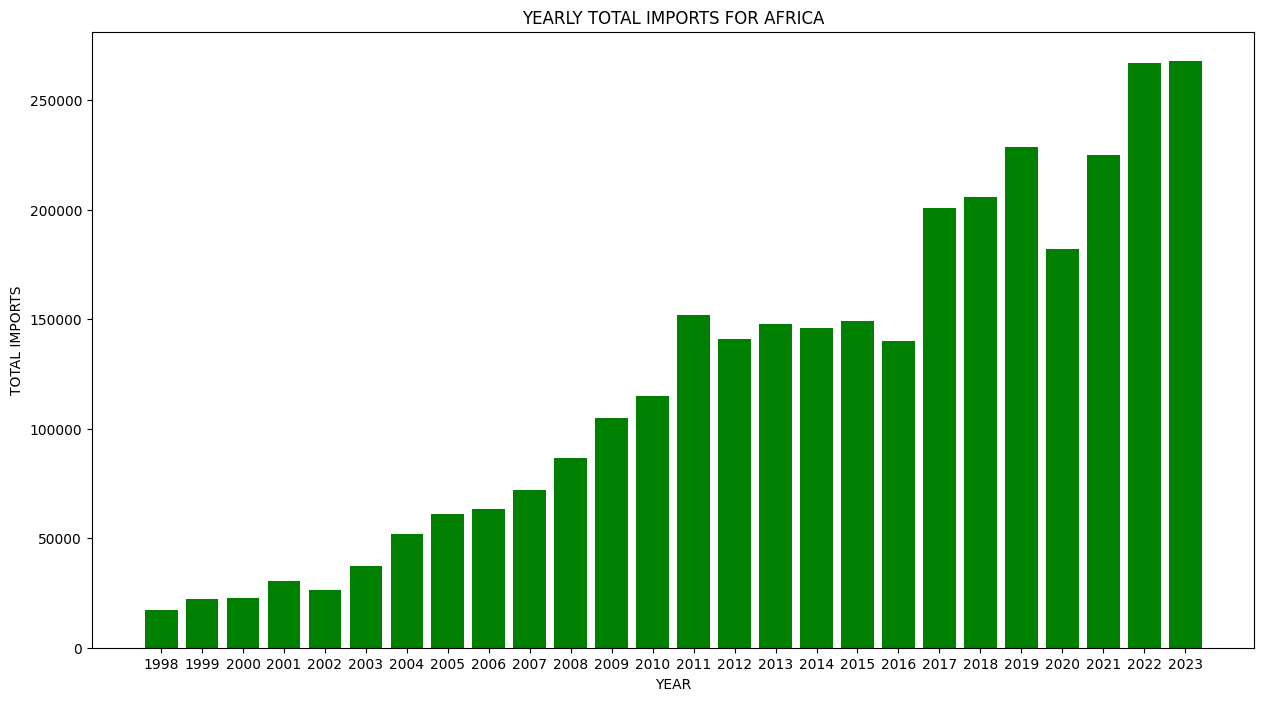

In [93]:
## Getting the year that had the highest imports
## Grouping the data by year and summing up the totals for each year
yearly_imports = africa_imports.groupby('Year')['Total'].sum()
yearly_imports

# Creating a dataframe of the yearly imports
africa_imports_df = pd.DataFrame(yearly_imports)

# Creating a bar plot

plt.figure(figsize=(15,8))
plt.bar(africa_imports_df.index,africa_imports_df.Total,color='green')
plt.title('YEARLY TOTAL IMPORTS FOR AFRICA')
plt.xlabel('YEAR')
plt.ylabel('TOTAL IMPORTS')

plt.xticks(africa_imports_df.index)

**Insights:**
- African countries had the highest imports in 2023 and the lowest imports in 1998.


([<matplotlib.axis.XTick at 0x2c7ef6f8c10>,
 [Text(0.0, 0, 'April'),
  Text(1.0, 0, 'August'),
  Text(2.0, 0, 'December'),
  Text(3.0, 0, 'February'),
  Text(4.0, 0, 'January'),
  Text(5.0, 0, 'July'),
  Text(6.0, 0, 'June'),
  Text(7.0, 0, 'March'),
  Text(8.0, 0, 'May'),
  Text(9.0, 0, 'November'),
  Text(10.0, 0, 'October'),
  Text(11.0, 0, 'September')])

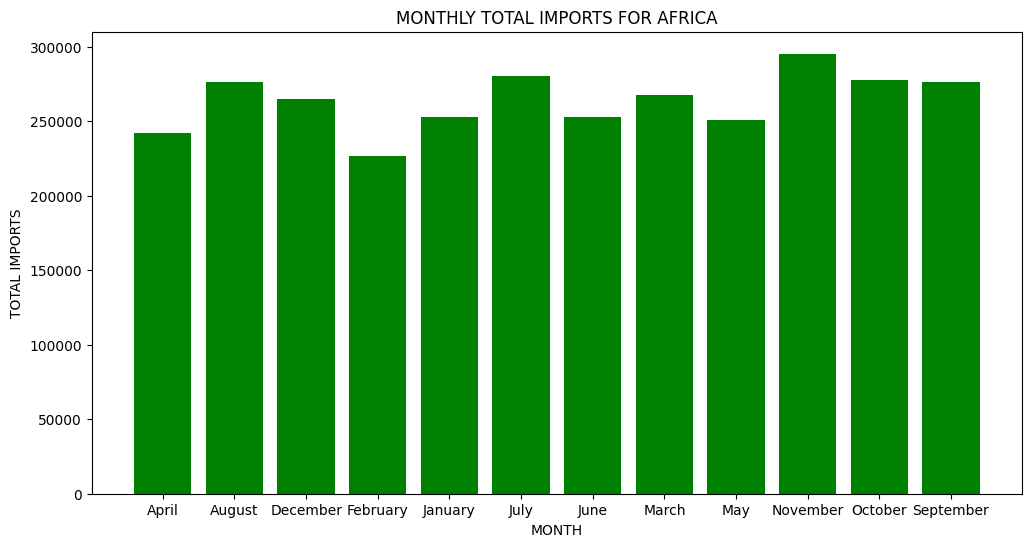

In [94]:
## Getting the african country that had the highest imports

## Getting the year that had the highest imports
## Grouping the data by year and summing up the totals for each year
monthly_imports = africa_imports.groupby('Month')['Total'].sum()
monthly_imports

# Creating a dataframe of the monthly imports
africa_monthly_imports_df = pd.DataFrame(monthly_imports)

# Creating a bar plot

plt.figure(figsize=(12,6))
plt.bar(africa_monthly_imports_df.index,africa_monthly_imports_df.Total,color='green')
plt.title('MONTHLY TOTAL IMPORTS FOR AFRICA')
plt.xlabel('MONTH')
plt.ylabel('TOTAL IMPORTS')

plt.xticks(africa_monthly_imports_df.index, )

**Insights:**
- Africa had the highest amount of imports in November while February had the lowest amount of imports

### Rest of the World Imports

In [95]:
outside_africa_imports = imports[['Year.1','Month.1','UK','USA','Germany','Italy','UAE','S.Arabia','France','India','S.Africa.1','Japan','Others','Total.1']]
outside_africa_imports

,Year.1,Month.1,UK,USA,Germany,Italy,UAE,S.Arabia,France,India,S.Africa.1,Japan,Others,Total.1
0,2023,June,3588,12020,5178,1695,32248,7655,2330,21412,6748,8748,108546,210166
1,2023,December,2435,8453,3382,1709,31030,5007,2500,19295,5125,8877,131851,219664
2,2023,January,3658,5769,2995,1740,33077,4013,4376,24201,3267,6822,105295,195214
3,2023,February,2509,5766,3695,963,35619,7170,1436,13993,5790,5670,93461,176071
4,2023,March,2479,6916,2916,2678,13925,32265,2052,27320,7319,8033,111778,217680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1998,September,1958,375,957,408,1333,1024,669,825,973,2470,6526,16949
308,1998,November,2249,844,807,389,719,720,610,662,1118,1009,5682,13820
309,1998,December,2074,596,1271,397,1657,2976,681,663,998,1396,6029,18046
310,1998,January,1871,1273,1178,543,2873,1169,847,598,1229,1059,4959,16634


([<matplotlib.axis.XTick at 0x2c7ef7dc250>,
 [Text(1998, 0, '1998'),
  Text(1999, 0, '1999'),
  Text(2000, 0, '2000'),
  Text(2001, 0, '2001'),
  Text(2002, 0, '2002'),
  Text(2003, 0, '2003'),
  Text(2004, 0, '2004'),
  Text(2005, 0, '2005'),
  Text(2006, 0, '2006'),
  Text(2007, 0, '2007'),
  Text(2008, 0, '2008'),
  Text(2009, 0, '2009'),
  Text(2010, 0, '2010'),
  Text(2011, 0, '2011'),
  Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022'),
  Text(2023, 0, '2023')])

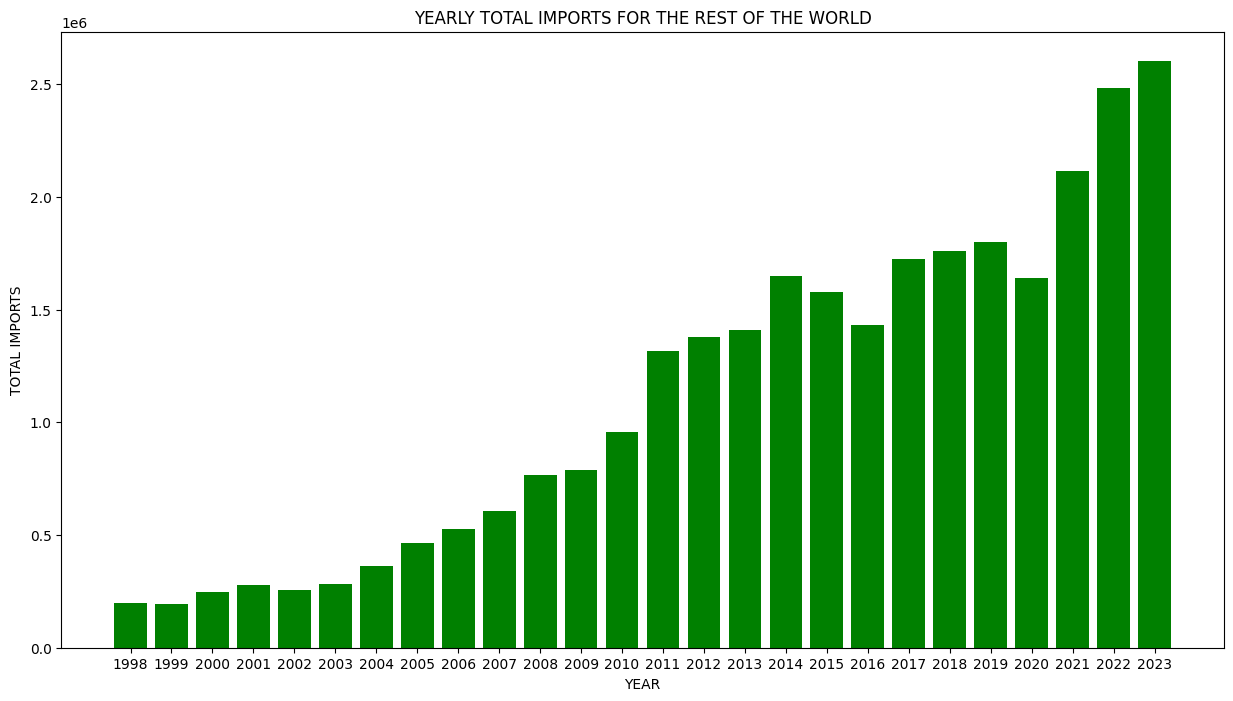

In [96]:
## Getting the year that had the highest imports
## Grouping the data by year and summing up the totals for each year
outside_africa_yearly_imports = outside_africa_imports.groupby('Year.1')['Total.1'].sum()
outside_africa_yearly_imports

# Creating a dataframe of the yearly imports
outside_africa_imports_df = pd.DataFrame(outside_africa_yearly_imports)

# Creating a bar plot

plt.figure(figsize=(15,8))
plt.bar(outside_africa_imports_df.index,outside_africa_imports_df['Total.1'],color='green')
plt.title('YEARLY TOTAL IMPORTS FOR THE REST OF THE WORLD')
plt.xlabel('YEAR')
plt.ylabel('TOTAL IMPORTS')

plt.xticks(outside_africa_imports_df.index, )

**Insights:**
- In the rest of the world, 2023 had the highest imports and the lowest imports were in 1999

Text(0, 0.5, 'TOTAL IMPORTS')

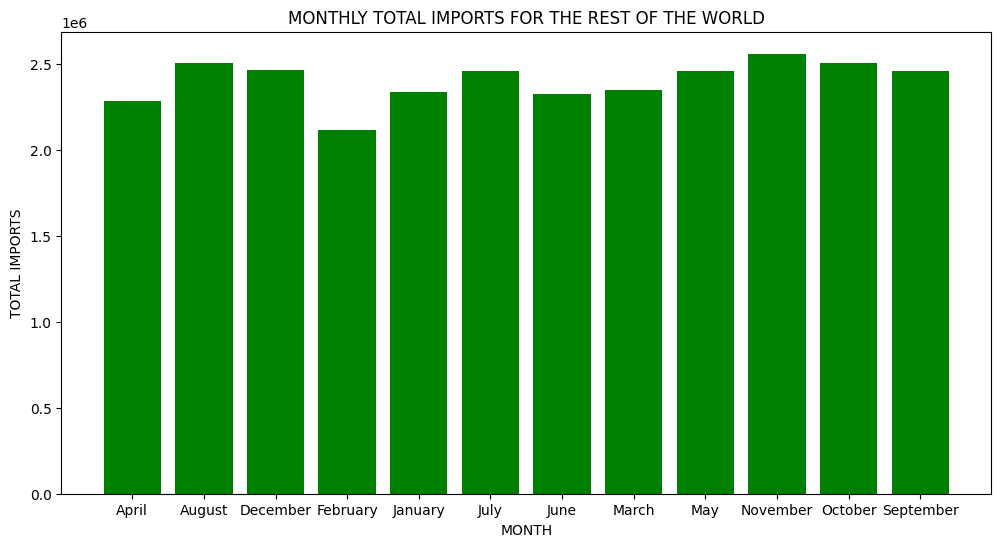

In [97]:
## Getting the year that had the highest imports
## Grouping the data by year and summing up the totals for each year
outside_africa_monthly_imports = outside_africa_imports.groupby('Month.1')['Total.1'].sum()
outside_africa_monthly_imports

# Creating a dataframe of the monthly imports
outside_africa_monthly_imports_df = pd.DataFrame(outside_africa_monthly_imports)
outside_africa_monthly_imports_df

# Creating a bar plot

plt.figure(figsize=(12,6))
plt.bar(outside_africa_monthly_imports_df.index,outside_africa_monthly_imports_df['Total.1'],color='green')
plt.title('MONTHLY TOTAL IMPORTS FOR THE REST OF THE WORLD')
plt.xlabel('MONTH')
plt.ylabel('TOTAL IMPORTS')

**Insights:**
- The rest of the world experienced high imports, in the month of November and low imports in the month of February.

In [98]:
# Dropping the year.1 and Month.1 column
imports_df = imports.drop(['Year.1','Month.1'],axis=1)


In [99]:
# Combining the two total columns
imports_df['Combined_Total']=imports_df['Total']+ imports_df['Total.1']

# Dropping the individual total columns
imports_df = imports_df.drop(['Total','Total.1'],axis=1)

# Renaming columns in the data set
column_names={'Other':'Other_Africa','Others':'Other_World'}
imports_df.rename(columns=column_names,inplace=True)

In [100]:
imports_df

,Year,Month,Uganda,Tanzania,Zambia,Egypt,S.Africa,Zimbabwe,Other_Africa,UK,USA,Germany,Italy,UAE,S.Arabia,France,India,S.Africa.1,Japan,Other_World,Combined_Total
0,2023,June,3039,3915,599,4325,6748,791,2263,3588,12020,5178,1695,32248,7655,2330,21412,6748,8748,108546,231846
1,2023,December,2134,3470,340,4359,5125,450,3745,2435,8453,3382,1709,31030,5007,2500,19295,5125,8877,131851,239286
2,2023,January,2922,2386,181,3517,3267,93,9409,3658,5769,2995,1740,33077,4013,4376,24201,3267,6822,105295,216990
3,2023,February,3016,2692,232,3313,5790,208,2441,2509,5766,3695,963,35619,7170,1436,13993,5790,5670,93461,193762
4,2023,March,3191,2909,213,4741,7319,361,3682,2479,6916,2916,2678,13925,32265,2052,27320,7319,8033,111778,240096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1998,September,2,56,21,10,973,19,81,1958,375,957,408,1333,1024,669,825,973,2470,6526,18111
308,1998,November,9,61,1,9,1118,25,188,2249,844,807,389,719,720,610,662,1118,1009,5682,15230
309,1998,December,2,105,0,51,998,36,310,2074,596,1271,397,1657,2976,681,663,998,1396,6029,19548
310,1998,January,2,39,13,16,1229,30,109,1871,1273,1178,543,2873,1169,847,598,1229,1059,4959,18072


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


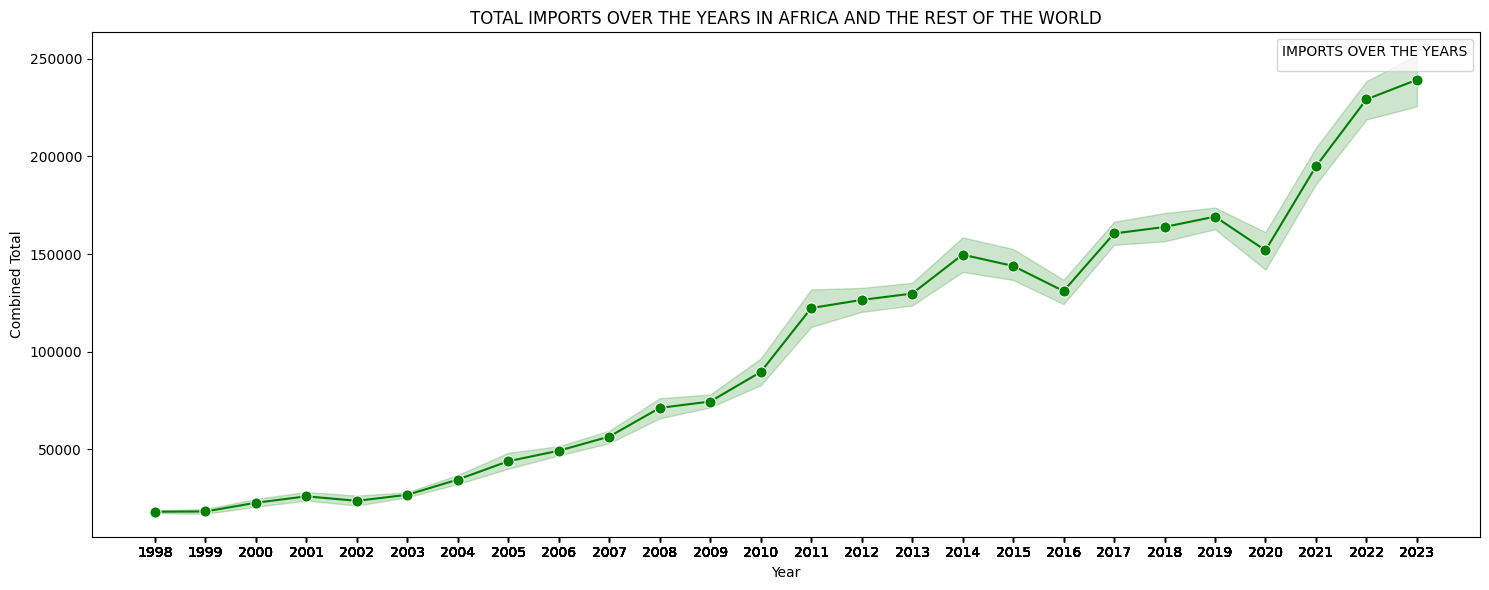

In [101]:
# Attempting to use seaborn

# Plotting a line plot using Seaborn
plt.figure(figsize=(15, 6))
sns.lineplot(data=imports_df,x='Year', y='Combined_Total', marker='o', markersize=8,color='green')

# Adjust the plot appearance
plt.title('TOTAL IMPORTS OVER THE YEARS IN AFRICA AND THE REST OF THE WORLD')
plt.xlabel('Year')
plt.ylabel('Combined Total')
plt.legend(title='IMPORTS OVER THE YEARS', bbox_to_anchor=(1, 1))
plt.xticks(imports_df['Year'])
plt.tight_layout()

# Show the plot
plt.show()


### Checking for stationarity

1. Writing down the hypothesis:

     - Null hypothesis: Non-stationary          vs           Alternative hypothesis: Stationary

2. Defining the level of significance: alpha = 0.05

3. Stationarity test : ADF test



In [102]:
# Performing the adf test
result = adfuller(imports_df['Combined_Total'])
# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis; the time series is stationary.")
else:
    print("Fail to reject the null hypothesis; the time series is not stationary.")


ADF Statistic: -2.0533793261750284
p-value: 0.26366921309730385
Critical Values: {'1%': -3.4525611751768914, '5%': -2.87132117782556, '10%': -2.5719816428028888}
Fail to reject the null hypothesis; the time series is not stationary.


**Insights:**
- The time series for imports is not stationary

## Exports Data

In [103]:
export=pd.read_csv("Value of Exports to Selected African & Rest of World Countries (Ksh Million).csv")

# first few observations
export.head()

,Year,Month,UK,Germany,USA,Netherlands,Uganda,Tanzania,Pakistan,France,Egypt,Belgium,Others,Total,Year.1,Month.1,Uganda.1,Tanzania.1,Zambia,Egypt.1,Rwanda,Zimbabwe,Ethiopia,Somalia,S.Africa,DRC,Other,Total.1
0,2023,June,4199,1975,6054,6260,10806,5741,7326,1548,3290,1087,37542,85829,2023,June,10806,5741,826,3290,3324,266,1846,1620,246,1826,5837,35629
1,2023,December,5148,929,5731,6758,9536,5557,7293,1263,2475,442,39107,84239,2023,December,9536,5557,737,2475,3286,268,1472,1420,443,2283,6562,34039
2,2023,January,4230,1199,5512,5843,9930,4404,4435,1145,2199,1806,32249,72951,2023,January,9930,4404,641,2199,3153,183,1162,1069,500,1564,4929,29734
3,2023,February,4716,1553,4396,6088,10043,4676,3868,963,2284,328,37767,76683,2023,February,10043,4676,910,2284,2945,205,1477,2454,538,2160,5992,33683
4,2023,March,4566,1716,5250,5975,11076,4922,5700,931,2703,238,38696,81772,2023,March,11076,4922,682,2703,3272,159,1531,1474,705,1799,7036,35358


In [104]:
export.columns

Index(['Year', 'Month', 'UK', 'Germany', 'USA', 'Netherlands', 'Uganda',
       'Tanzania', 'Pakistan', 'France', 'Egypt', 'Belgium', 'Others', 'Total',
       'Year.1', 'Month.1', 'Uganda.1', 'Tanzania.1', 'Zambia', 'Egypt.1',
       'Rwanda', 'Zimbabwe', 'Ethiopia', 'Somalia', 'S.Africa', 'DRC', 'Other',
       'Total.1'],
      dtype='object')

### Africa Exports 

In [105]:
africaExports=export[[ 'Year.1', 'Month.1', 'Uganda.1', 'Tanzania.1', 'Zambia', 'Egypt.1',
       'Rwanda', 'Zimbabwe', 'Ethiopia', 'Somalia', 'S.Africa', 'DRC', 'Other',
       'Total.1']]
africaExports.head()

,Year.1,Month.1,Uganda.1,Tanzania.1,Zambia,Egypt.1,Rwanda,Zimbabwe,Ethiopia,Somalia,S.Africa,DRC,Other,Total.1
0,2023,June,10806,5741,826,3290,3324,266,1846,1620,246,1826,5837,35629
1,2023,December,9536,5557,737,2475,3286,268,1472,1420,443,2283,6562,34039
2,2023,January,9930,4404,641,2199,3153,183,1162,1069,500,1564,4929,29734
3,2023,February,10043,4676,910,2284,2945,205,1477,2454,538,2160,5992,33683
4,2023,March,11076,4922,682,2703,3272,159,1531,1474,705,1799,7036,35358


In [106]:
# Descriptive Statistics
africaExports.describe()

,Year.1,Uganda.1,Tanzania.1,Zambia,Egypt.1,Rwanda,Zimbabwe,Ethiopia,Somalia,S.Africa,DRC,Other,Total.1
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000
mean,2010.500000,4501.951923,2515.532051,362.483974,1262.224359,1169.089744,84.980769,454.705128,915.391026,247.657051,1074.730769,2842.153846,15430.894231
std,7.512048,2259.265981,1266.652481,238.444867,689.996771,947.882920,96.797363,353.378662,584.126617,215.013051,775.730746,1676.402108,8100.737444
min,1998.000000,904.000000,699.000000,1.000000,0.000000,132.000000,0.000000,71.000000,10.000000,9.000000,86.000000,328.000000,3906.000000
25%,2004.000000,2625.500000,1405.750000,194.750000,612.500000,406.500000,20.000000,204.750000,358.250000,103.000000,532.500000,1351.250000,7851.500000
50%,2010.500000,4314.000000,2447.000000,376.500000,1216.000000,965.000000,56.000000,367.000000,927.000000,204.000000,1064.500000,2969.000000,16120.000000
75%,2017.000000,5603.500000,3182.250000,503.500000,1740.000000,1457.250000,121.500000,574.500000,1321.750000,322.500000,1518.250000,3814.750000,20211.500000
max,2023.000000,12170.000000,7437.000000,1555.000000,3447.000000,4990.000000,776.000000,2413.000000,3177.000000,1533.000000,9943.000000,7511.000000,42006.000000


**Insights Drawn:**
- Within all the countries in Africa, Uganda had the highest number of maximum exports; it also has a high standard deviation implying  presence of outliers.
- The maximum total exports in Africa is 42006 and the minimum number of exports in Africa is 3906.

([<matplotlib.axis.XTick at 0x2c7f80bc3d0>,
 [Text(1998, 0, '1998'),
  Text(1999, 0, '1999'),
  Text(2000, 0, '2000'),
  Text(2001, 0, '2001'),
  Text(2002, 0, '2002'),
  Text(2003, 0, '2003'),
  Text(2004, 0, '2004'),
  Text(2005, 0, '2005'),
  Text(2006, 0, '2006'),
  Text(2007, 0, '2007'),
  Text(2008, 0, '2008'),
  Text(2009, 0, '2009'),
  Text(2010, 0, '2010'),
  Text(2011, 0, '2011'),
  Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022'),
  Text(2023, 0, '2023')])

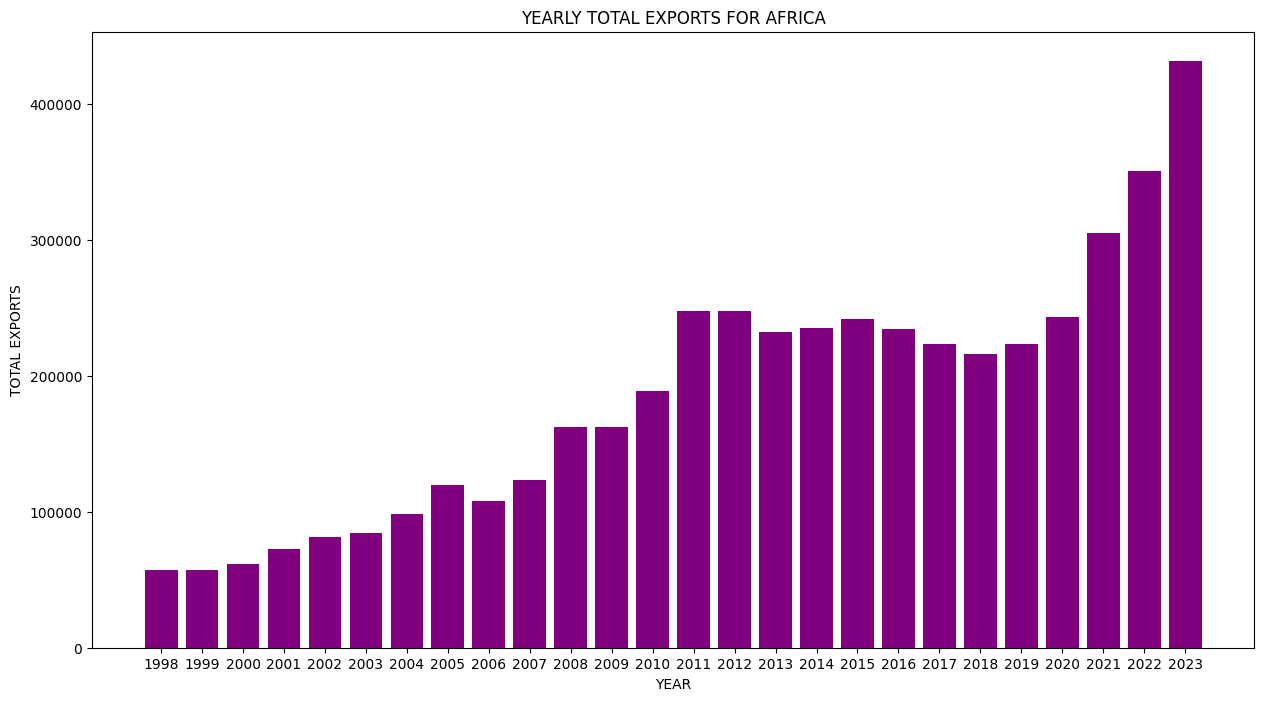

In [107]:
## Yearly Exports in Africa

## Grouping the data by year and summing up the totals for each year
yearly_exports = africaExports.groupby('Year.1')['Total.1'].sum()
yearly_exports

# Creating a dataframe of the yearly imports
africa_exports_df = pd.DataFrame(yearly_exports)

# Creating a bar plot

plt.figure(figsize=(15,8))
plt.bar(africa_exports_df.index,africa_exports_df['Total.1'],color='purple')
plt.title('YEARLY TOTAL EXPORTS FOR AFRICA')
plt.xlabel('YEAR')
plt.ylabel('TOTAL EXPORTS')

plt.xticks(africa_imports_df.index)

**Insights:**
- Africa experieced highest exports in 2023.

In [108]:
# Monthly Exports in Africa

## Grouping the data by year and summing up the totals for each year
monthly_exports = africaExports.groupby('Month.1')['Total.1'].sum()
monthly_exports

# Creating a dataframe of the monthly imports
africa_monthly_exports_df = pd.DataFrame(monthly_exports)
africa_monthly_exports_df


,Total.1
Month.1,
April,377350
August,419243
December,396403
February,394089
January,353959
July,422069
June,396745
March,416657
May,401406


([<matplotlib.axis.XTick at 0x2c7f8182e10>,
 [Text(0.0, 0, 'April'),
  Text(1.0, 0, 'August'),
  Text(2.0, 0, 'December'),
  Text(3.0, 0, 'February'),
  Text(4.0, 0, 'January'),
  Text(5.0, 0, 'July'),
  Text(6.0, 0, 'June'),
  Text(7.0, 0, 'March'),
  Text(8.0, 0, 'May'),
  Text(9.0, 0, 'November'),
  Text(10.0, 0, 'October'),
  Text(11.0, 0, 'September')])

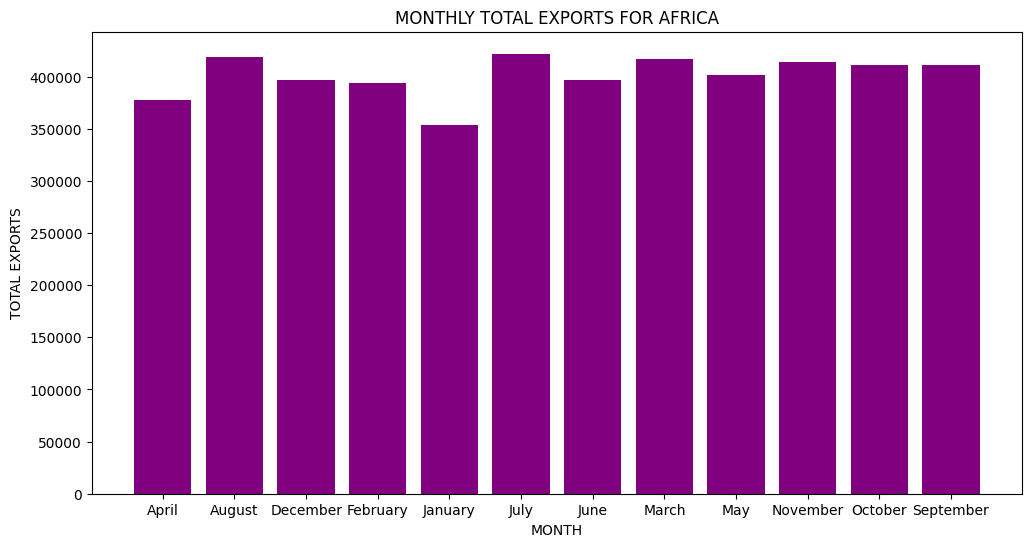

In [109]:
# Creating a bar plot

plt.figure(figsize=(12,6))
plt.bar(africa_monthly_exports_df.index,africa_monthly_exports_df['Total.1'],color='purple')
plt.title('MONTHLY TOTAL EXPORTS FOR AFRICA')
plt.xlabel('MONTH')
plt.ylabel('TOTAL EXPORTS')

plt.xticks(africa_monthly_exports_df.index)


**Insights:**
- Africa experienced the highest number of exports in July

### Rest of the World Exports

In [110]:
#Extracting rest of the world data
worldExports=export[['Year', 'Month', 'UK', 'Germany', 'USA', 'Netherlands', 'Uganda',
       'Tanzania', 'Pakistan', 'France', 'Egypt', 'Belgium', 'Others', 'Total']]
worldExports

,Year,Month,UK,Germany,USA,Netherlands,Uganda,Tanzania,Pakistan,France,Egypt,Belgium,Others,Total
0,2023,June,4199,1975,6054,6260,10806,5741,7326,1548,3290,1087,37542,85829
1,2023,December,5148,929,5731,6758,9536,5557,7293,1263,2475,442,39107,84239
2,2023,January,4230,1199,5512,5843,9930,4404,4435,1145,2199,1806,32249,72951
3,2023,February,4716,1553,4396,6088,10043,4676,3868,963,2284,328,37767,76683
4,2023,March,4566,1716,5250,5975,11076,4922,5700,931,2703,238,38696,81772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1998,September,1010,309,194,358,1809,1534,859,160,410,96,3123,9861
308,1998,November,1361,395,202,476,1492,1353,586,138,397,148,2541,9089
309,1998,December,1180,356,189,592,1758,1461,497,196,549,100,2719,9597
310,1998,January,1420,266,261,456,1386,1326,683,138,410,105,3073,9524


In [111]:
# Descriptive statistics
worldExports.describe()

,Year,UK,Germany,USA,Netherlands,Uganda,Tanzania,Pakistan,France,Egypt,Belgium,Others,Total
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000
mean,2010.500000,2832.391026,718.573718,2333.044872,2649.506410,4501.951923,2516.541667,2363.608974,470.400641,1262.224359,370.352564,15997.121795,36015.692308
std,7.512048,1008.605778,357.712347,1928.953513,1656.573067,2259.265981,1266.977462,1888.732068,280.528629,689.996771,267.696060,9772.054282,20075.194946
min,1998.000000,559.000000,196.000000,118.000000,234.000000,904.000000,699.000000,10.000000,84.000000,0.000000,62.000000,2201.000000,9007.000000
25%,2004.000000,1916.000000,440.000000,344.750000,1367.250000,2625.500000,1405.750000,919.750000,265.500000,612.500000,187.000000,6981.250000,17287.500000
50%,2010.500000,2978.500000,634.000000,1922.000000,2405.000000,4314.000000,2447.000000,1516.500000,409.000000,1216.000000,294.500000,16732.000000,38399.500000
75%,2017.000000,3539.250000,923.500000,3703.500000,3668.000000,5603.500000,3182.250000,3861.250000,602.250000,1740.000000,465.500000,22799.500000,49141.000000
max,2023.000000,5422.000000,2358.000000,10517.000000,8431.000000,12170.000000,7437.000000,9898.000000,1746.000000,3447.000000,1825.000000,43614.000000,94270.000000


**Insights Drawn:**
- Other rest of the world countries had the maximum number of exports (43614), throughout the years.
- The maximum number of exports experienced By the World througout the years is 94270

([<matplotlib.axis.XTick at 0x2c7f1860150>,
 [Text(1998, 0, '1998'),
  Text(1999, 0, '1999'),
  Text(2000, 0, '2000'),
  Text(2001, 0, '2001'),
  Text(2002, 0, '2002'),
  Text(2003, 0, '2003'),
  Text(2004, 0, '2004'),
  Text(2005, 0, '2005'),
  Text(2006, 0, '2006'),
  Text(2007, 0, '2007'),
  Text(2008, 0, '2008'),
  Text(2009, 0, '2009'),
  Text(2010, 0, '2010'),
  Text(2011, 0, '2011'),
  Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022'),
  Text(2023, 0, '2023')])

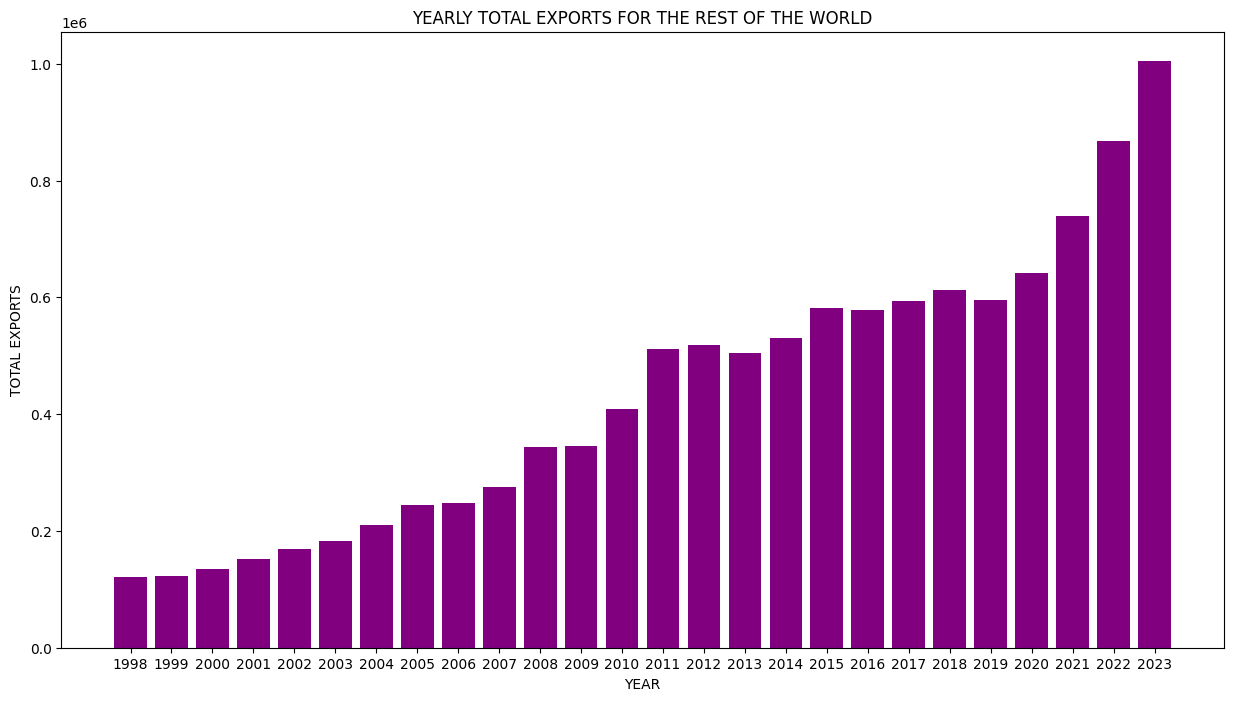

In [112]:
## Yearly rest of the world exports

## Grouping the data by year and summing up the totals for each year
world_yearly_exports = worldExports.groupby('Year')['Total'].sum()
world_yearly_exports

# Creating a dataframe of the yearly imports
world_exports_df = pd.DataFrame(world_yearly_exports)

# Creating a bar plot

plt.figure(figsize=(15,8))
plt.bar(world_exports_df.index,world_exports_df['Total'],color='purple')
plt.title('YEARLY TOTAL EXPORTS FOR THE REST OF THE WORLD')
plt.xlabel('YEAR')
plt.ylabel('TOTAL EXPORTS')

plt.xticks(outside_africa_imports_df.index)


**Insight Drawn:**
- The rest of the world had the highest number of exports in 2023.

In [113]:
# Monthly Rest of the world exports

## Grouping the data by year and summing up the totals for each year
world_monthly_exports = worldExports.groupby('Month')['Total'].sum()
world_monthly_exports

# Creating a dataframe of the yearly imports
monthly_world_exports_df = pd.DataFrame(world_monthly_exports)
monthly_world_exports_df



,Total
Month,
April,877204
August,943276
December,917002
February,946962
January,881092
July,963680
June,937325
March,982071
May,952319


([<matplotlib.axis.XTick at 0x2c7f188d190>,
 [Text(0.0, 0, 'April'),
  Text(1.0, 0, 'August'),
  Text(2.0, 0, 'December'),
  Text(3.0, 0, 'February'),
  Text(4.0, 0, 'January'),
  Text(5.0, 0, 'July'),
  Text(6.0, 0, 'June'),
  Text(7.0, 0, 'March'),
  Text(8.0, 0, 'May'),
  Text(9.0, 0, 'November'),
  Text(10.0, 0, 'October'),
  Text(11.0, 0, 'September')])

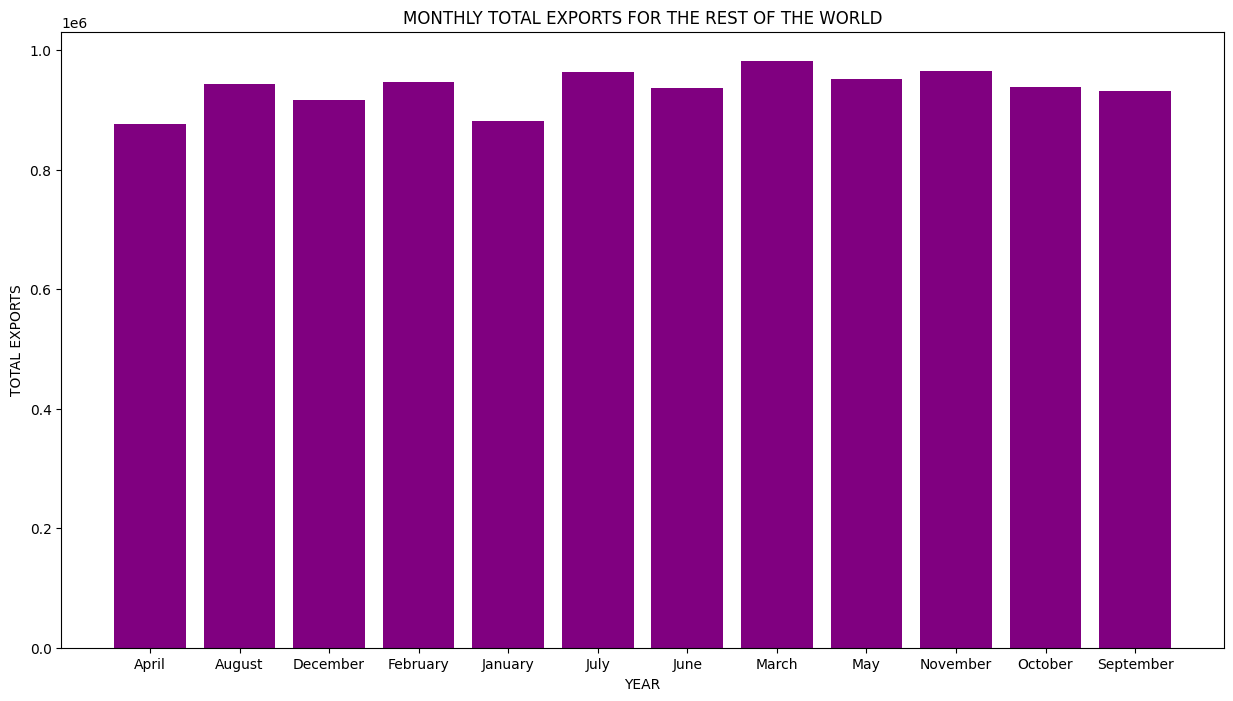

In [114]:
# Creating a bar plot

plt.figure(figsize=(15,8))
plt.bar(monthly_world_exports_df.index,monthly_world_exports_df['Total'],color='purple')
plt.title('MONTHLY TOTAL EXPORTS FOR THE REST OF THE WORLD')
plt.xlabel('YEAR')
plt.ylabel('TOTAL EXPORTS')

plt.xticks(monthly_world_exports_df.index)


**Insights:**
- The rest of the world experienced the highest number of exports in July

### Combined Africa and Rest of the world

In [115]:
# Dropping the year.1 and Month.1 column
exports_df = export.drop(['Year.1','Month.1'],axis=1)

# Combining the two total columns
exports_df['Combined_Total']=exports_df['Total']+ exports_df['Total.1']

# Dropping the individual total columns
exports_df = exports_df.drop(['Total','Total.1'],axis=1)

# Renaming columns in the data set
column_names={'Other':'Other_Africa','Others':'Other_World'}
exports_df.rename(columns=column_names,inplace=True)



In [116]:
exports_df

,Year,Month,UK,Germany,USA,Netherlands,Uganda,Tanzania,Pakistan,France,Egypt,Belgium,Other_World,Uganda.1,Tanzania.1,Zambia,Egypt.1,Rwanda,Zimbabwe,Ethiopia,Somalia,S.Africa,DRC,Other_Africa,Combined_Total
0,2023,June,4199,1975,6054,6260,10806,5741,7326,1548,3290,1087,37542,10806,5741,826,3290,3324,266,1846,1620,246,1826,5837,121458
1,2023,December,5148,929,5731,6758,9536,5557,7293,1263,2475,442,39107,9536,5557,737,2475,3286,268,1472,1420,443,2283,6562,118278
2,2023,January,4230,1199,5512,5843,9930,4404,4435,1145,2199,1806,32249,9930,4404,641,2199,3153,183,1162,1069,500,1564,4929,102685
3,2023,February,4716,1553,4396,6088,10043,4676,3868,963,2284,328,37767,10043,4676,910,2284,2945,205,1477,2454,538,2160,5992,110366
4,2023,March,4566,1716,5250,5975,11076,4922,5700,931,2703,238,38696,11076,4922,682,2703,3272,159,1531,1474,705,1799,7036,117130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1998,September,1010,309,194,358,1809,1534,859,160,410,96,3123,1809,1534,19,410,326,71,119,195,83,86,511,15024
308,1998,November,1361,395,202,476,1492,1353,586,138,397,148,2541,1492,1353,11,397,216,5,120,157,64,131,459,13493
309,1998,December,1180,356,189,592,1758,1461,497,196,549,100,2719,1758,1461,35,549,297,5,154,214,42,180,458,14751
310,1998,January,1420,266,261,456,1386,1326,683,138,410,105,3073,1386,1326,12,410,335,25,107,160,95,215,328,13923


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


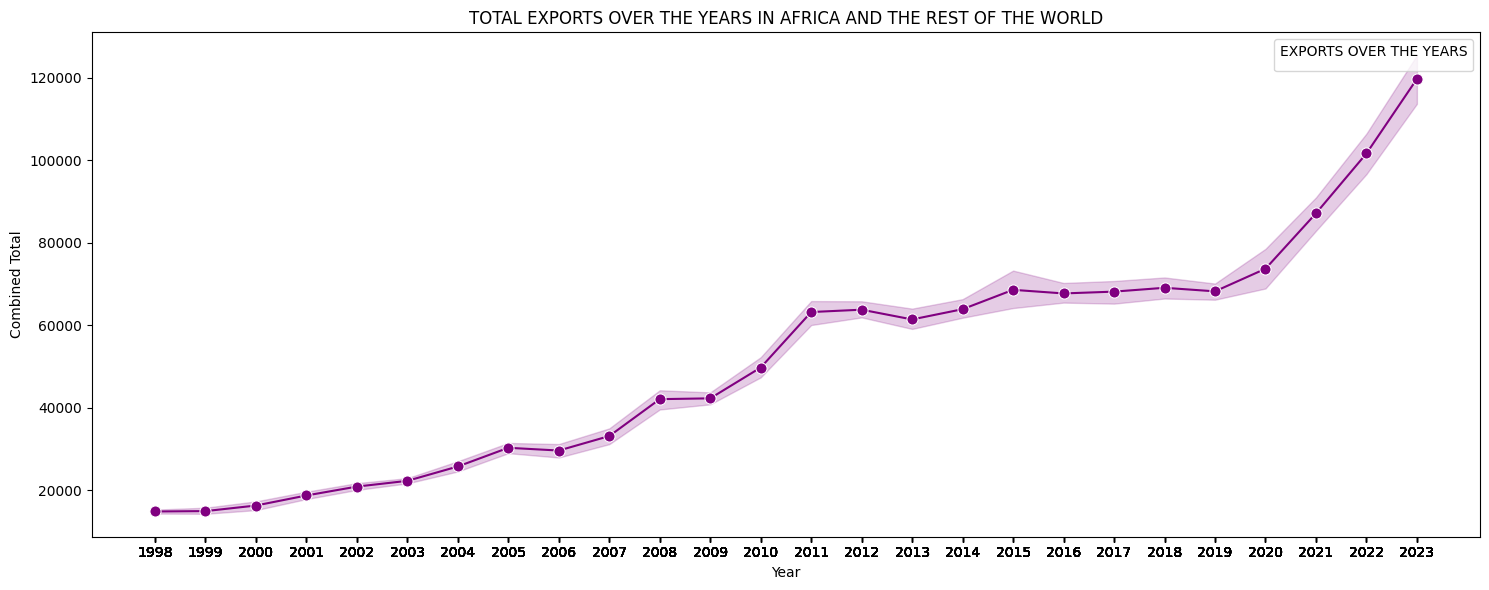

In [117]:
# Attempting to use seaborn

# Plotting a line plot using Seaborn
plt.figure(figsize=(15, 6))
sns.lineplot(data=exports_df,x='Year', y='Combined_Total', marker='o', markersize=8,color='purple')

# Adjust the plot appearance
plt.title('TOTAL EXPORTS OVER THE YEARS IN AFRICA AND THE REST OF THE WORLD')
plt.xlabel('Year')
plt.ylabel('Combined Total')
plt.legend(title='EXPORTS OVER THE YEARS', bbox_to_anchor=(1, 1))
plt.xticks(exports_df['Year'])
plt.tight_layout()

# Show the plot
plt.show()


#### Checking for stationarity

1. Writing down the hypothesis:

     - Null hypothesis: Non-stationary          vs           Alternative hypothesis: Stationary

2. Defining the level of significance: alpha = 0.05

3. Stationarity test : ADF test



In [118]:
# Performing the adf test
exp_result = adfuller(exports_df['Combined_Total'],autolag='AIC')

# Print the results
print('ADF Statistic:', exp_result[0])
print('p-value:', exp_result[1])
print('Critical Values:', exp_result[4])

# Interpret the results
if exp_result[1] <= 0.05:
    print("Reject the null hypothesis; the time series is stationary.")
else:
    print("Fail to reject the null hypothesis; the time series is not stationary.")


ADF Statistic: -3.880767812271555
p-value: 0.0021810339143779126
Critical Values: {'1%': -3.4523371197407404, '5%': -2.871222860740741, '10%': -2.571929211111111}
Reject the null hypothesis; the time series is stationary.


- The exports data is stationary

## Summary on Data Understanding

### Exchange Rate Data
- The maximum exchange rate from 1998 to 2023 is 154.09 with the minimum as 59.34.
- Since the mean is > than the median(50%), suggest that the exchange rate is skewed to the right, suggesting presence of outliers
- From the ADF test, exchange rate data was found to be stationary

### Imports Data 
- The maximum imports for Africa from 1998 to 2023  is 27075.
- The country with the maximum imports for Africa was other African countries with a value of 9409.
- African countries had the highest imports in 2023 and the lowest imports in 1998.
- Africa had the highest amount of imports in November while February had the lowest amount of imports
- The rest of the world experienced high imports in  2023 and the lowest imports were in 1999
- The rest of the world experienced high imports, in the month of November and low imports in the month of February.
- From the ADF test, the imports data was found to be non-stationary

### Exports Data
- Africa experienced highest exports in 2023.
- Africa experienced highest exports in the month of July.
- The rest of the world had the highest exports in 2023.
- The rest of the world had the highest exports in the month of July.
- From the ADF test,the exports data was found to be stationary



---------------------
# Research Question: What is the relationship between Exchange Rate and Trade Balances?
---------------------

# Starting with a single country -> Egypt

Hypothesis:

* Null hypothesis: No significant relationship between the exchange rate and trade balances

* Alternative hypothesis : Significant relationship between the exchange rate and trade balances

In [119]:
# Extracting Egypt imports
egypt_imports=imports_df[['Year','Month','Egypt']]


# Extracting Egypt exports
egypt_exports=exports_df[['Year','Month','Egypt']]

# Replacing month names with numeric values
month = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}

# Replace month names with numeric values
egypt_imports['Month'] = egypt_imports['Month'].map(month)
egypt_exports['Month'] = egypt_exports['Month'].map(month)

# Sort the DataFrame based on 'Year' and 'Month'
exchange_data = exchange_data.sort_values(by=['Year', 'Month'],ascending=[False, False])


# Sort the DataFrame based on 'Year' and 'Month'
egypt_imports = egypt_imports.sort_values(by=['Year', 'Month'],ascending=[False, False])

# Sort the DataFrame based on 'Year' and 'Month'
egypt_exports = egypt_exports.sort_values(by=['Year', 'Month'],ascending=[False, False])


# Merge the three DataFrames on 'Year' and 'Month'
egypt = pd.merge(exchange_data, egypt_imports, on=['Year', 'Month'])
egypt = pd.merge(egypt, egypt_exports, on=['Year', 'Month'])
egypt

# Renaming the columns
# Renaming columns in the data set
column_names={'Egypt_x':'EgyptImports','Egypt_y':'EgyptExports'}
egypt.rename(columns=column_names,inplace=True)


C:\Users\USER\AppData\Local\Temp\ipykernel_21208\2367360929.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egypt_imports['Month'] = egypt_imports['Month'].map(month)
C:\Users\USER\AppData\Local\Temp\ipykernel_21208\2367360929.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egypt_exports['Month'] = egypt_exports['Month'].map(month)


In [120]:
# Convert 'Year' and 'Month' to datetime
egypt['Date'] = pd.to_datetime(egypt[['Year', 'Month']].assign(DAY=1))

# Drop the original 'Year' and 'Month' columns
egypt = egypt.drop(['Year', 'Month'], axis=1)

# Reorder columns if needed
egypt = egypt[['Date', 'fx rate', 'EgyptImports', 'EgyptExports']]
egypt

,Date,fx rate,EgyptImports,EgyptExports
0,2023-12-01,154.09,4359,2475
1,2023-11-01,152.03,4053,2689
2,2023-10-01,149.40,5526,3447
3,2023-09-01,146.77,3889,2685
4,2023-08-01,143.93,4185,3394
...,...,...,...,...
307,1998-05-01,62.60,16,541
308,1998-04-01,59.61,9,611
309,1998-03-01,60.13,18,708
310,1998-02-01,60.52,17,440


In [121]:
egypt=egypt.set_index('Date')

In [122]:
egypt.index

DatetimeIndex(['2023-12-01', '2023-11-01', '2023-10-01', '2023-09-01',
               '2023-08-01', '2023-07-01', '2023-06-01', '2023-05-01',
               '2023-04-01', '2023-03-01',
               ...
               '1998-10-01', '1998-09-01', '1998-08-01', '1998-07-01',
               '1998-06-01', '1998-05-01', '1998-04-01', '1998-03-01',
               '1998-02-01', '1998-01-01'],
              dtype='datetime64[ns]', name='Date', length=312, freq=None)

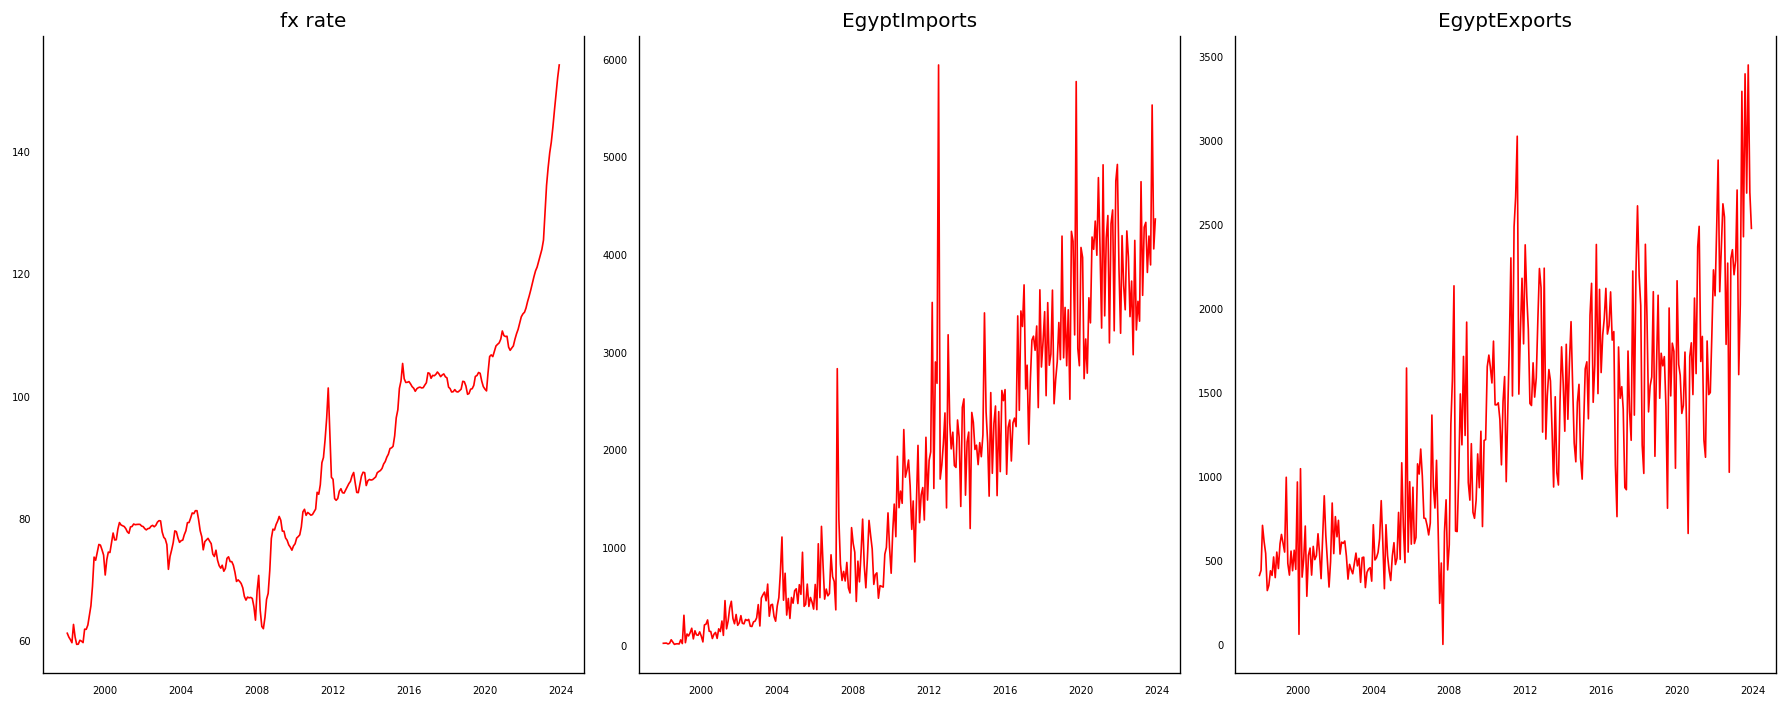

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=120, figsize=(15,6))
for i, ax in enumerate(axes.flatten()):
    data = egypt[egypt.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(egypt.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

###

### Checking for stationarity of the exchange rate , imports and exports

In [124]:
ad_fuller_result_1 = adfuller(egypt['fx rate'])

print('Fx Rate')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(egypt['EgyptImports'].diff()[1:])

print('Egypt Imports')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')


print('\n---------------------\n')

ad_fuller_result_3 = adfuller(egypt['EgyptExports'].diff()[1:])

print('Egypt Exports')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')



Fx Rate
ADF Statistic: -3.200432852094083
p-value: 0.0199596377074848

---------------------

Egypt Imports
ADF Statistic: -8.341229246624824
p-value: 3.1721296973892917e-13

---------------------

Egypt Exports
ADF Statistic: -8.341229246624824
p-value: 3.1721296973892917e-13


In [125]:
egypt

,fx rate,EgyptImports,EgyptExports
Date,,,
2023-12-01,154.09,4359,2475
2023-11-01,152.03,4053,2689
2023-10-01,149.40,5526,3447
2023-09-01,146.77,3889,2685
2023-08-01,143.93,4185,3394
...,...,...,...
1998-05-01,62.60,16,541
1998-04-01,59.61,9,611
1998-03-01,60.13,18,708


### Checking for correlation between exchange rate , imports and exports

<Axes: >

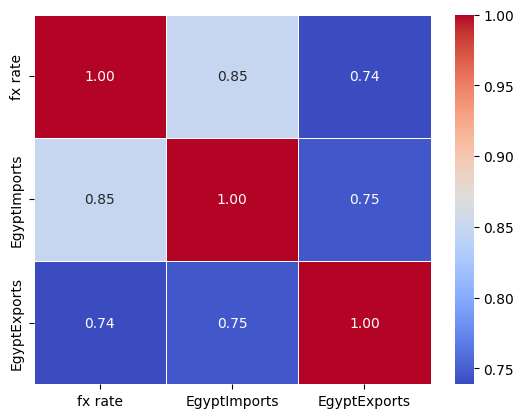

In [126]:
# checking the correlation
corr = egypt.corr()

# Drawing a heat map
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)


**Insight:**
- High correlation between the exchange rate and imports
- High correlation between the exchange rate and exports.

# Using Time Series Models

### A. GrangerCausality Tests

- Is a statistical concept used to determine whether one time series can predict the future values of another time series.
- A prerequisite for performing the Granger Causality test is that the data need to be stationary.

In [127]:
egypt

,fx rate,EgyptImports,EgyptExports
Date,,,
2023-12-01,154.09,4359,2475
2023-11-01,152.03,4053,2689
2023-10-01,149.40,5526,3447
2023-09-01,146.77,3889,2685
2023-08-01,143.93,4185,3394
...,...,...,...
1998-05-01,62.60,16,541
1998-04-01,59.61,9,611
1998-03-01,60.13,18,708


#### Data preparation - The data is differenced

In [128]:
# Differecing the exports and imports
egypt['Diff_egyptExports']=egypt['EgyptExports'].diff()[1:]
egypt['Diff_egyptImports']=egypt['EgyptImports'].diff()[1:]
egypt=egypt.dropna()

In [129]:
egypt

,fx rate,EgyptImports,EgyptExports,Diff_egyptExports,Diff_egyptImports
Date,,,,,
2023-11-01,152.03,4053,2689,214.0,-306.0
2023-10-01,149.40,5526,3447,758.0,1473.0
2023-09-01,146.77,3889,2685,-762.0,-1637.0
2023-08-01,143.93,4185,3394,709.0,296.0
2023-07-01,141.45,3812,2425,-969.0,-373.0
...,...,...,...,...,...
1998-05-01,62.60,16,541,221.0,-36.0
1998-04-01,59.61,9,611,70.0,-7.0
1998-03-01,60.13,18,708,97.0,9.0


<Axes: xlabel='Date'>

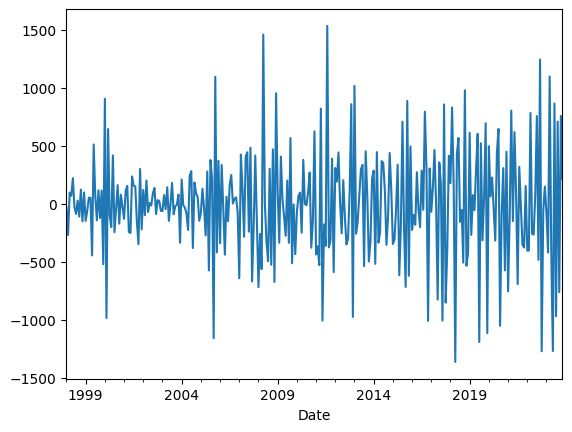

In [130]:
# Lineplot of the differenced exports
egypt['Diff_egyptExports'].plot()

<Axes: xlabel='Date'>

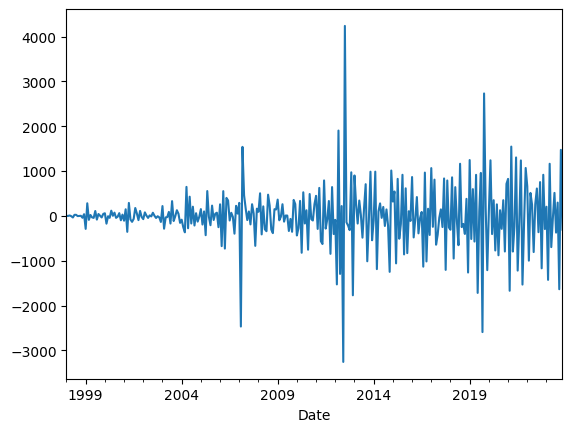

In [131]:
#lineplot of the differenced imports
egypt['Diff_egyptImports'].plot()

#### Performing the test

Defining the hypothesis:

* Null hypothesis: Exchange Rate does not granger cause imports and exports
* Alternative hypothesis :  Exchange Rate does granger cause imports and exports

In [132]:
egypt.columns

Index(['fx rate', 'EgyptImports', 'EgyptExports', 'Diff_egyptExports',
       'Diff_egyptImports'],
      dtype='object')

In [133]:
# Taking the differenced data from Egypt
diff_egypt= egypt[['fx rate', 'Diff_egyptExports', 'Diff_egyptImports']]

In [134]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(diff_egypt, variables = diff_egypt.columns)  

c:\Users\USER\Desktop\Exchange_Rate\exchangeRate\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\USER\Desktop\Exchange_Rate\exchangeRate\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\USER\Desktop\Exchange_Rate\exchangeRate\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\USER\Desktop\Exchange_Rate\exchangeRate\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\USER\Desktop\Exchange_Rate\exchangeRate\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\USER\D

,fx rate_x,Diff_egyptExports_x,Diff_egyptImports_x
fx rate_y,1.0000,0.1050,0.0001
Diff_egyptExports_y,0.0134,1.0000,0.4462
Diff_egyptImports_y,0.7057,0.0141,1.0000


**Insight:**
- The row are the Response (Y) and the columns are the predictor series (X)
- The p-value of exports causing exchange rate is 0.105, since the p-value is greater than 0.05, thus exports does not cause exchange rate.
- The p-value of exports causing exchange rate is 0.0001, since the p-value is less than 0.05, thus imports causes exchange rate.
- Looking at the P-Values in the above table, you can pretty much observe that not all the variables (time series) in the system are interchangeably causing each other.

#### Splitting the data into train and test

In [135]:
# Define features and target variable
X = diff_egypt.drop(['fx rate'], axis=1)
y = diff_egypt['fx rate']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a dataframe for the y_train
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)


# Combining the train and test dataset
train=pd.concat([X_train,y_train],axis=1)
test=pd.concat([X_test,y_test],axis=1)



### B. VAR Model

#### Selecting the order (p) of the VAR model

In [143]:
var_model = VAR(diff_egypt)
sorted_order=var_model.select_order(maxlags=8)
print(sorted_order.summary())
     

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       30.75       30.79   2.273e+13       30.77
1       25.44       25.59   1.120e+11       25.50
2       25.12      25.38*   8.105e+10       25.22
3       25.07       25.44   7.747e+10      25.22*
4       25.05       25.52   7.541e+10       25.24
5      25.03*       25.62  7.429e+10*       25.27
6       25.07       25.77   7.713e+10       25.35
7       25.09       25.89   7.847e+10       25.41
8       25.10       26.02   7.962e+10       25.47
-------------------------------------------------


c:\Users\USER\Desktop\Exchange_Rate\exchangeRate\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Exchange_Rate\exchangeRate\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [144]:
model = VAR(train)
model_fit = model.fit(maxlags=5)
model_fit.summary()

c:\Users\USER\Desktop\Exchange_Rate\exchangeRate\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\Desktop\Exchange_Rate\exchangeRate\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 14, Mar, 2024
Time:                     10:42:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    32.0409
Nobs:                     243.000    HQIC:                   31.6288
Log likelihood:          -4795.54    FPE:                4.12830e+13
AIC:                      31.3509    Det(Omega_mle):     3.40950e+13
--------------------------------------------------------------------
Results for equation Diff_egyptExports
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                     -116.301424       351.698015           -0.331           0.741
L1.Diff_egyptExports        -0.069508         0.067365           -1.032           0.302
L1.Diff_egyptImports

In [145]:
# Getting the lags used in the model
lag = model_fit.k_ar
# Using 
model_fit.forecast(train.values[-lag:],steps=5)

array([[  17.00562973, -106.08553947,   87.65857435],
       [  95.40403508,   35.48836359,   90.18932924],
       [  -1.69476691,  -16.8486158 ,   86.02037201],
       [  79.24950733,   25.08273616,   84.92426601],
       [  11.36806847,   23.60938601,   85.65126324]])

In [146]:
test[0:5]

,Diff_egyptExports,Diff_egyptImports,fx rate
Date,,,
1999-09-01,117.0,42.0,75.68
2023-02-01,-419.0,-1428.0,125.45
2019-02-01,-268.0,-516.0,100.23
2018-11-01,-534.0,380.0,102.36
2021-10-01,-353.0,-1533.0,110.86


### C. Impulse Response Analysis

- Impulse response analysis is an important step in econometric analyes, which employ vector autoregressive models. 
- Their main purpose is to describe the evolution of a model’s variables in reaction to a shock in one or more variables.
- in each plot the blue line represents the IRF and the black lines represent the confidence intervals. 

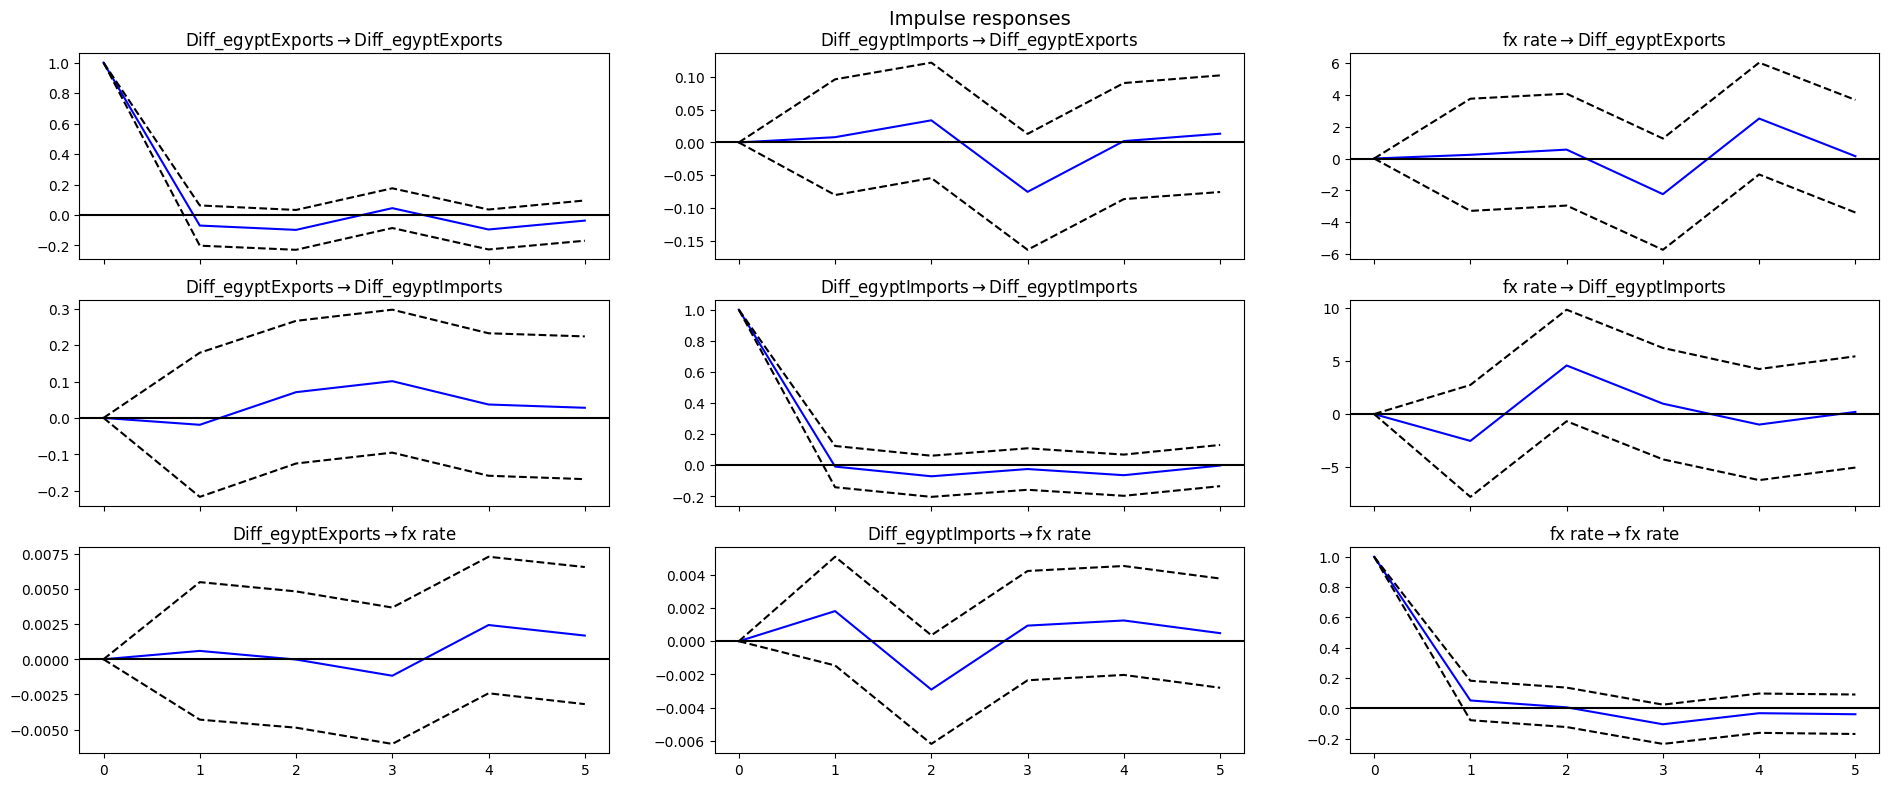

In [147]:
# Impulse response function
# Compute impulse response function
irf = model_fit.irf(lag)
# Plot impulse response functions

irf.plot(figsize=(20, 8))
plt.show()


**Insights:**
- A shock to the exchange rate,slightly increases the exports from Egypt up to the second month, and a decrease in the exports is experienced between the second and third month, an increase is then experienced between the third and fourth month.
- A shock to the exchange rate, slightly decreases the imports in the first month, an increase in the imports is experineced between the first and second month.

# Using Machine Learning Algorithms

- Before machine learning can be used, time series forecasting problems must be re-framed as supervised learning problems. This can be done by  shifting the dataset. 

In [148]:
clean_egypt = egypt.drop(['Diff_egyptExports','Diff_egyptImports'],axis=1)

### Shifting the variables once - Lag 1

In [149]:
## Adding lags to the dataset
clean_egypt['t-1_fx rate']= clean_egypt['fx rate'].shift(+1)
clean_egypt['t-1_EgyptImports']=clean_egypt['EgyptImports'].shift(+1)
clean_egypt['t-1_EgyptExports']=clean_egypt['EgyptExports'].shift(+1)

clean_egypt

,fx rate,EgyptImports,EgyptExports,t-1_fx rate,t-1_EgyptImports,t-1_EgyptExports
Date,,,,,,
2023-11-01,152.03,4053,2689,NaN,NaN,NaN
2023-10-01,149.40,5526,3447,152.03,4053.0,2689.0
2023-09-01,146.77,3889,2685,149.40,5526.0,3447.0
2023-08-01,143.93,4185,3394,146.77,3889.0,2685.0
2023-07-01,141.45,3812,2425,143.93,4185.0,3394.0
...,...,...,...,...,...,...
1998-05-01,62.60,16,541,60.52,52.0,320.0
1998-04-01,59.61,9,611,62.60,16.0,541.0
1998-03-01,60.13,18,708,59.61,9.0,611.0


In [150]:
# Dropping the null values
clean_egypt=clean_egypt.dropna()
clean_egypt

,fx rate,EgyptImports,EgyptExports,t-1_fx rate,t-1_EgyptImports,t-1_EgyptExports
Date,,,,,,
2023-10-01,149.40,5526,3447,152.03,4053.0,2689.0
2023-09-01,146.77,3889,2685,149.40,5526.0,3447.0
2023-08-01,143.93,4185,3394,146.77,3889.0,2685.0
2023-07-01,141.45,3812,2425,143.93,4185.0,3394.0
2023-06-01,139.73,4325,3290,141.45,3812.0,2425.0
...,...,...,...,...,...,...
1998-05-01,62.60,16,541,60.52,52.0,320.0
1998-04-01,59.61,9,611,62.60,16.0,541.0
1998-03-01,60.13,18,708,59.61,9.0,611.0


In [151]:
# Defining the dependent and independent variables
X=clean_egypt.drop(['fx rate'],axis=1)
y=clean_egypt['fx rate']

In [152]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()
# Scaling the training dataset
X_scaled = scaler.fit_transform(X_train)

# Scaling  X_test 
X_test_scaled = scaler.transform(X_test)


In [153]:
X_test_df=pd.DataFrame(X_test_scaled)
y_test_df = pd.DataFrame(y_test)

# Sort the DataFrame by the index (date)
X_test_df = X_test_df.sort_index()
y_test_df = y_test_df.sort_index()


### Random Forest Regression

In [154]:
#Initializing the model
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)
model.fit(X_scaled,y_train)

RandomForestRegressor(max_features=3, random_state=1)

In [155]:
# Setting the index for the X_test
X_test_df= X_test_df.set_index(X_test.index)

In [156]:
# Using the model to make predictions
pred=model.predict(X_test_df)

# Setting the index of the predictions data frame
pred= pd.DataFrame(pred).set_index(y_test_df.index)

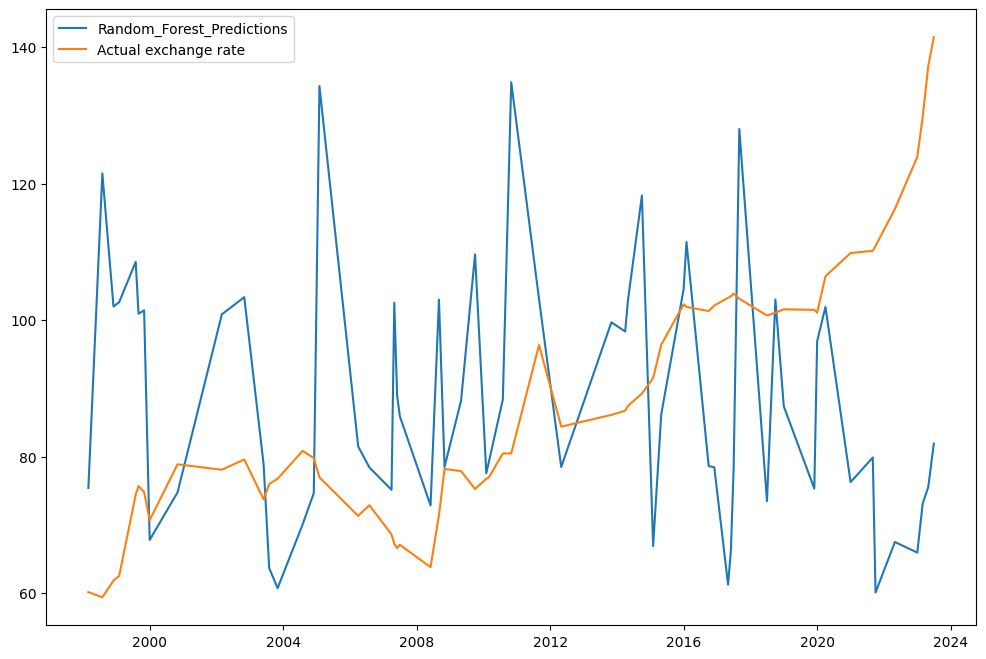

In [157]:
# Visualizing the actual values and predictions
plt.figure(figsize=(12,8))
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test_df,label='Actual exchange rate')
plt.legend(loc="upper left")
plt.show()

In [158]:
rmse_rf=sqrt(mean_squared_error(pred,y_test_df))
rmse_rf

29.20744936428752

## Determining the appropriate number of shifts to use in order to predict the future- using PACF and ACF

### For FX - Rate

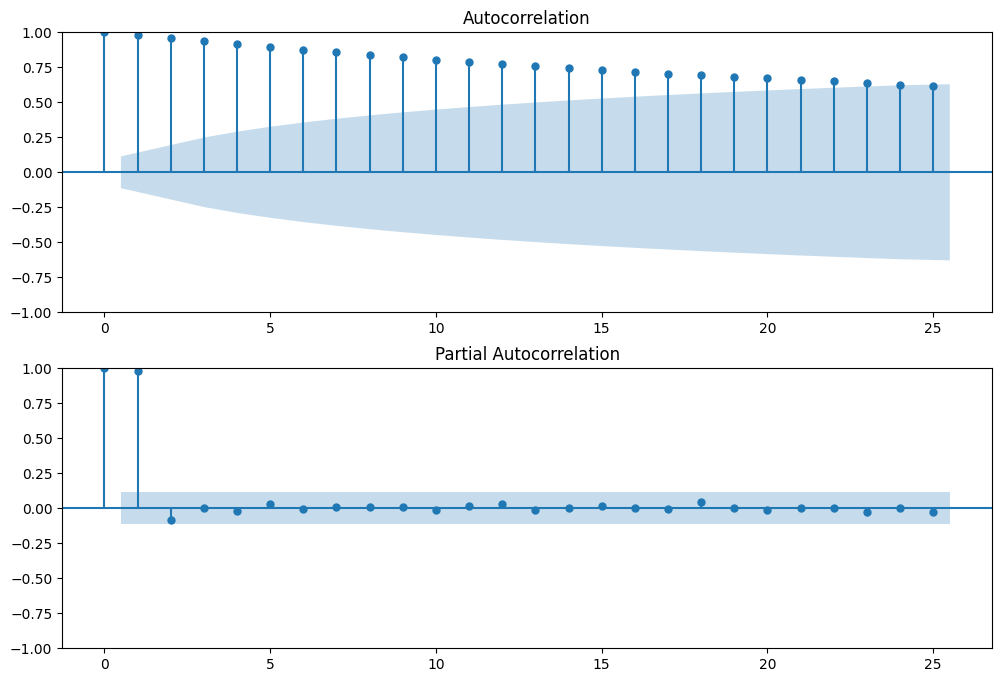

In [159]:
# ACF and PACF plot for exchange rate
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(egypt['fx rate'].iloc[13:],lags=25,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(egypt['fx rate'].iloc[13:],lags=25,ax=ax2)

**Insight**
- The most appropriate lags to use in order to predict fxRate is lag 1.

## For Imports

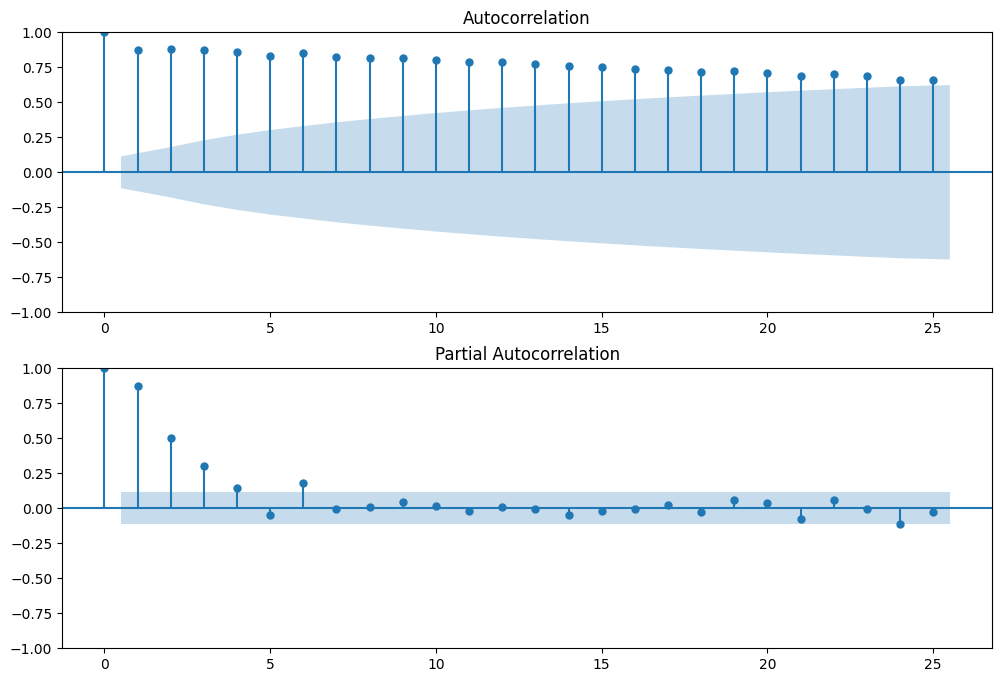

In [160]:
# ACF and pacf plot for imports
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(egypt['EgyptImports'].iloc[13:],lags=25,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(egypt['EgyptImports'].iloc[13:],lags=25,ax=ax2)

- The most apprpriate lags to use in order to predict imports is lag 4.

## For Exports

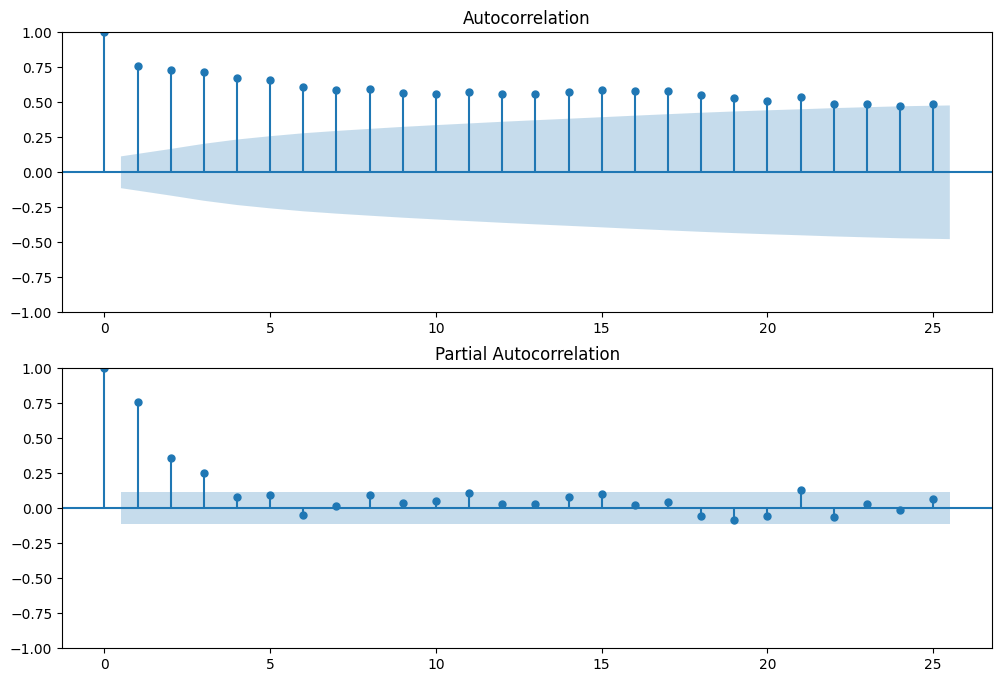

In [161]:
# ACF and pacf plot for exports
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(egypt['EgyptExports'].iloc[13:],lags=25,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(egypt['EgyptExports'].iloc[13:],lags=25,ax=ax2)

- The most appropriate lags to use in order to predict exports is lag 3.

## Shifting the variables based on the lags obtained from the ACF and PACF

In [164]:
## Adding lags to the dataset

egypt['t-1_fx rate']= egypt['fx rate'].shift(+1)
clean_egypt['t-2_EgyptImports']=clean_egypt['EgyptImports'].shift(+2)
clean_egypt['t-3_EgyptImports']=clean_egypt['EgyptImports'].shift(+3)
clean_egypt['t-4_EgyptImports']=clean_egypt['EgyptImports'].shift(+4)

clean_egypt['t-2_EgyptExports']=clean_egypt['EgyptExports'].shift(+2)
clean_egypt['t-3_EgyptExports']=clean_egypt['EgyptExports'].shift(+3)
#merged_df['t-4_EgyptExports']=merged_df['EgyptExports'].shift(+4)
clean_egypt

C:\Users\USER\AppData\Local\Temp\ipykernel_21208\3642160089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egypt['t-1_fx rate']= egypt['fx rate'].shift(+1)
C:\Users\USER\AppData\Local\Temp\ipykernel_21208\3642160089.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_egypt['t-2_EgyptImports']=clean_egypt['EgyptImports'].shift(+2)
C:\Users\USER\AppData\Local\Temp\ipykernel_21208\3642160089.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,fx rate,EgyptImports,EgyptExports,t-1_fx rate,t-1_EgyptImports,t-1_EgyptExports,t-2_EgyptImports,t-3_EgyptImports,t-4_EgyptImports,t-2_EgyptExports,t-3_EgyptExports
Date,,,,,,,,,,,
2023-10-01,149.40,5526,3447,152.03,4053.0,2689.0,NaN,NaN,NaN,NaN,NaN
2023-09-01,146.77,3889,2685,149.40,5526.0,3447.0,NaN,NaN,NaN,NaN,NaN
2023-08-01,143.93,4185,3394,146.77,3889.0,2685.0,5526.0,NaN,NaN,3447.0,NaN
2023-07-01,141.45,3812,2425,143.93,4185.0,3394.0,3889.0,5526.0,NaN,2685.0,3447.0
2023-06-01,139.73,4325,3290,141.45,3812.0,2425.0,4185.0,3889.0,5526.0,3394.0,2685.0
...,...,...,...,...,...,...,...,...,...,...,...
1998-05-01,62.60,16,541,60.52,52.0,320.0,29.0,5.0,10.0,351.0,438.0
1998-04-01,59.61,9,611,62.60,16.0,541.0,52.0,29.0,5.0,320.0,351.0
1998-03-01,60.13,18,708,59.61,9.0,611.0,16.0,52.0,29.0,541.0,320.0


In [169]:
# Defining the dependent and independent variables
X1=clean_egypt.drop(['fx rate'],axis=1)
y1=clean_egypt['fx rate']

# Split data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()
# Scaling the training dataset
X_scaled1 = scaler.fit_transform(X_train1)

# Scaling  X_test 
X_test_scaled1 = scaler.transform(X_test1)


In [170]:
X_test_df1=pd.DataFrame(X_test_scaled1)
y_test_df1 = pd.DataFrame(y_test1)

# Sort the DataFrame by the index (date)
X_test_df1 = X_test_df1.sort_index()
y_test_df1 = y_test_df1.sort_index()


## Fitting a Random Forest regression model

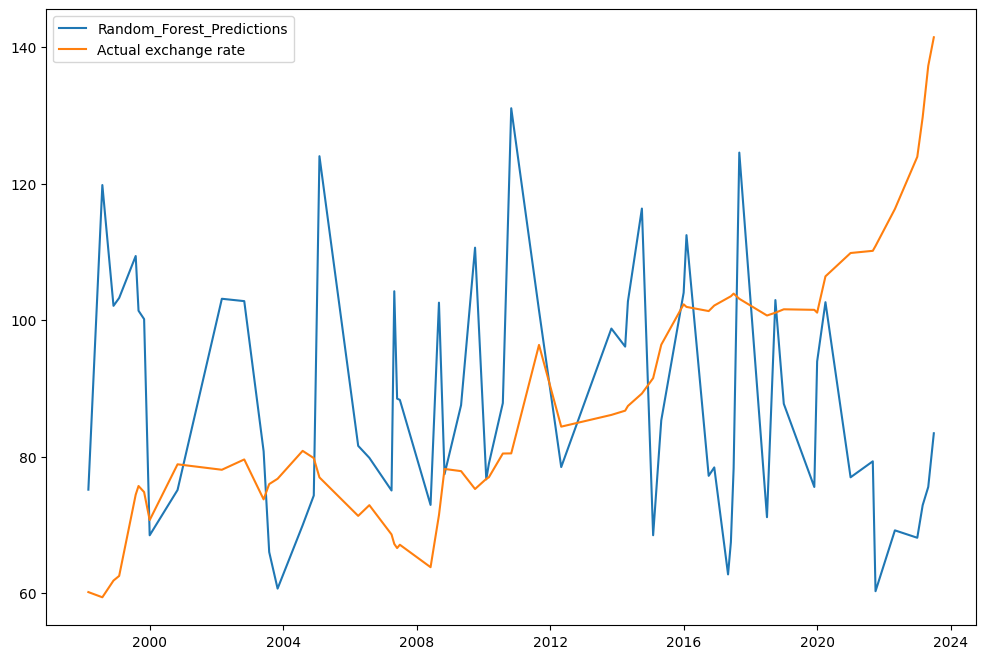

In [171]:
#Initializing the model
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)
model.fit(X_scaled1,y_train1)

# Setting the index for the X_test
X_test_df1= X_test_df1.set_index(X_test.index)

# Using the model to make predictions
pred1=model.predict(X_test_df1)

# Setting the index of the predictions data frame
pred1= pd.DataFrame(pred1).set_index(y_test_df1.index)

# Visualizing the actual values and predictions
plt.figure(figsize=(12,8))
plt.plot(pred1,label='Random_Forest_Predictions')
plt.plot(y_test_df1,label='Actual exchange rate')
plt.legend(loc="upper left")
plt.show()


In [172]:
rmse_rf=sqrt(mean_squared_error(pred1,y_test_df1))
rmse_rf

28.555224300213148

# The entire dataset

# Reference Articles
- https://neptune.ai/blog/time-series-prediction-vs-machine-learning
- https://www.anodot.com/blog/time-series-forecasting/
- https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
- 
- 